<a href="https://colab.research.google.com/github/alexncoleman/Wildfire-reinforcement-learning/blob/Centre-Ignition/Wildfire_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import math
import random
import copy
import random
#from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import animation as animation

from PIL import Image, ImageSequence
import matplotlib as mpl

import os
import random



In [2]:

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
##################################################################
#test with real map
#forest = Image.open('drive/MyDrive/CA/land_data/BigChimney_canopy.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Brattain_2020_ignition_forest.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/BigChimney_slope.tif')

#density = Image.open('drive/MyDrive/CA/land_data/BigChimney_density.tif')
###################################################################################


###################################################################################


#forest = Image.open('drive/MyDrive/CA/land_data/canopy_Ferguson_2018.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Ferguson_2018_ignition_forest.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/slope_Ferguson_2018.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

#density = Image.open('drive/MyDrive/CA/land_data/density_Ferguson_2018.tif')


###################################################################################
#test with real map
forest = Image.open('drive/MyDrive/ML/CA/land_data/canopy_Chimney_2016.tif')

ignition = np.loadtxt('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.txt').astype(int)
np.save('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.npy', ignition)
ignition = np.load('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.npy', mmap_mode = 'r').astype(int)

altitude = Image.open('drive/MyDrive/ML/CA/land_data/slope_Chimney_2016.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

density = Image.open('drive/MyDrive/ML/CA/land_data/density_Chimney_2016.tif')

###################################################################################
#test with real map
#forest = Image.open('drive/MyDrive/CA/land_data/canopy_JakeChimney_2016.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Chimney_2016_ignition_forest2.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/slope_JakeChimney_2016.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

#density = Image.open('drive/MyDrive/CA/land_data/density_JakeChimney_2016.tif')

In [4]:
np.array(forest).shape

(899, 982)

In [5]:
#plt.imshow(np.array(forest))

In [6]:
# def random_ignition(dim_x,dim_y):
#  field = np.ones((dim_x,dim_y))*2
#  x = random.randint(300,dim_x-300)
#  y = random.randint(300,dim_y-300)
#  for i in range(x,x+10):
#    for j in range(y,y+10):
#      field[i,j] = 3
#  return field

def random_ignition(dim_x,dim_y):
    field = np.ones((dim_x,dim_y))*2
    x = random.randint(30,dim_x-30)
    y = random.randint(30,dim_y-30)
    for i in range(x,x+4):
        for j in range(y,y+4):
            field[i,j] = 3
    return field.astype(int)

def centre_ignition(dim_x,dim_y):
    field = np.ones((dim_x,dim_y))*2
    x = round(dim_x/2)
    y = round(dim_y/2)
    for i in range(x,x+3):
        for j in range(y,y+3):
            field[i,j] = 3
    return field.astype(int)

In [7]:
forest = np.array(forest)

altitude = np.round(np.array(altitude)/np.max(altitude), 3)

density = np.array(density)

density = np.round(density/np.max(density), 3)

forest[forest<-999.] = 0.

forest = forest/np.max(forest)


from PIL import Image
from skimage.transform import resize

forest = resize(forest, (128, 128))
altitude = resize(altitude, (128, 128))
density = resize(density, (128, 128))

density = np.round(density/np.max(density))

n_row = forest.shape[0]
n_col = forest.shape[1]

number_MC = 20
#################################################################
generation = 501
n_row = forest.shape[0]
n_col = forest.shape[1]

In [8]:
def colormap(i,array):
    np_array = np.array(array)
    plt.imshow(np_array, interpolation="none", cmap=cm.plasma)
    plt.title(i)
    plt.show()

In [9]:
def init_vegetation():
    veg_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            veg_matrix[i][j] = 1
    return veg_matrix

def init_density():
    den_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            den_matrix[i][j] = 1.0
    return den_matrix.astype(int)

def init_altitude():
    alt_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            alt_matrix[i][j] = 1
    return alt_matrix

def init_forest():
    forest = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            forest[i][j] = 2
    # ignite_col = int(n_col//2)
    # ignite_row = int(n_row//2)
    ignite_col = int(n_col//2)
    ignite_row = int(100)
    for row in range(ignite_row-1, ignite_row+1):
        for col in range(ignite_col-1,ignite_col+1):
            forest[row][col] = 3
    # forest[ignite_row-2:ignite_row+2][ignite_col-2:ignite_col+2] = 3
    return forest.astype(int)


In [10]:
def print_forest(forest):
    for i in range(n_row):
        for j in range(n_col):
            sys.stdout.write(str(forest[i][j]))
        sys.stdout.write("\n")

In [11]:
def tg(x):
    return math.degrees(math.atan(x))

In [12]:
def get_slope(altitude_matrix):
    slope_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for row in range(n_row):
        for col in range(n_col):
            sub_slope_matrix = [[0,0,0],[0,0,0],[0,0,0]]
            if row == 0 or row == n_row-1 or col == 0 or col == n_col-1:  # margin is flat
                slope_matrix[row][col] = sub_slope_matrix
                continue
            current_altitude = altitude_matrix[row][col]
            sub_slope_matrix[0][0] = tg((current_altitude - altitude_matrix[row-1][col-1])/1.414)
            sub_slope_matrix[0][1] = tg(current_altitude - altitude_matrix[row-1][col])
            sub_slope_matrix[0][2] = tg((current_altitude - altitude_matrix[row-1][col+1])/1.414)
            sub_slope_matrix[1][0] = tg(current_altitude - altitude_matrix[row][col-1])
            sub_slope_matrix[1][1] = 0
            sub_slope_matrix[1][2] = tg(current_altitude - altitude_matrix[row][col+1])
            sub_slope_matrix[2][0] = tg((current_altitude - altitude_matrix[row+1][col-1])/1.414)
            sub_slope_matrix[2][1] = tg(current_altitude - altitude_matrix[row+1][col])
            sub_slope_matrix[2][2] = tg((current_altitude - altitude_matrix[row+1][col+1])/1.414)
            slope_matrix[row][col] = sub_slope_matrix
    return slope_matrix

In [13]:
def simulation(stage, per_bar_time, temp_bar_time, make_fig=False, forest_before_bar=None, whole_time=None, per_bar_input=None, temp_bar_input=None, max_per_len=None, max_temp_len=None):
    """
    input:
    stage = before bar:1, after bar:2
    bar_time = when is the bar was set
    bar_input = matrix of bar
    max_per_len = the maxmimum length of the permanent bar
    max_temp_len = the maxmimum length of the temporary bar

    output:
        stage1: the list of forest matrix before bar in time sequence
        stage2: loss
    """
    ###########################################################################
    #init

    #ignition = random_ignition(np.array(forest).shape[0],np.array(forest).shape[1]).astype(int)
    ignition = centre_ignition(np.array(forest).shape[0], np.array(forest).shape[1]).astype(int)

    #np.save('drive/MyDrive/CA/VAE/ignition/ignition_Brattain_'+str(index)+'.npy',ignition)

    V = 5. # need to find the true wind data
    p_h = 0.58
    a = 0.078
    c_1 = 0.045
    c_2 = 0.131

    ##############################################################################
    def calc_pw(theta,c_1,c_2,V):
        t = math.radians(theta)
        ft = math.exp(V*c_2*(math.cos(t)-1))
        return math.exp(c_1*V)*ft

    def count_3_and_4(matrix): #counting burned area
        count = 0
        for row in matrix:
            for element in row:
                if element == 3 or element == 4:
                    count += 1
        return count

    def get_wind():

      #wind_matrix = [[0 for col in [0,1,2]] for row in [0,1,2]]

      #thetas = [[0,180,180], #need to define the exact angle
      #          [180,0,180],
      #          [180,180,0]]

      #thetas = [[45,0,45], #need to define the exact angle
                #[90,0,90],
                #[135,180,135]]

      #for row in [0,1,2]:
          #for col in [0,1,2]:
              #wind_matrix[row][col] = calc_pw(thetas[row][col],c_1,c_2,V)
      #wind_matrix[1][1] = 0
        wind_matrix = [[1,0.5,0], #need to define the exact angle
                  [0.5,0,0],
                  [0,0,0]]
        return wind_matrix

    def burn_or_not_burn(abs_row, abs_col, neighbour_matrix, p_h,a): #removed p_bar = 0.1 from inputs
        p_veg = vegetation_matrix[abs_row][abs_col]
        p_den = {0:-0.4,1:0,2:0.3}[density_matrix[abs_row][abs_col]]
        for row in [0,1,2]:
            for col in [0,1,2]:
                if neighbour_matrix[row][col] == 3: # we only care there is a neighbour that is burning
                    # print(row,col)
                    slope = slope_matrix[abs_row][abs_col][row][col]
                    p_slope = math.exp(a * slope)
                    p_wind = wind_matrix[row][col]
                    p_burn = p_h * (0.5 + p_veg*10.) * (1 + p_den) * p_wind * p_slope
                    if p_burn > random.random():
                        return 3  #start burning
        return 2 # not burning

    def permanant_burn_or_not_burn(abs_row, abs_col, neighbour_matrix, p_h,a, p_bar=0.05): #determining if cells with barriers get burnt, assuming barriers have a burn probability of 0.05
        p_veg = vegetation_matrix[abs_row][abs_col]
        p_den = {0:-0.4,1:0,2:0.3}[density_matrix[abs_row][abs_col]]
        for row in [0,1,2]:
            for col in [0,1,2]:
                if neighbour_matrix[row][col] == 3:
                    slope = slope_matrix[abs_row][abs_col][row][col]
                    p_slope = math.exp(a * slope)
                    p_wind = wind_matrix[row][col]
                    p_burn = p_h * (0.5 + p_veg*10.) * (1 + p_den) * p_wind * p_slope * p_bar
                    if p_burn > random.random():
                        return 3  #start burning
        return 5 # not burning

    def update_forest(old_forest):
        result_forest = [[1 for i in range(n_col)] for j in range(n_row)]
        for row in range(1, n_row-1):
            for col in range(1, n_col-1):

                if old_forest[row][col] == 1 or old_forest[row][col] == 4 or old_forest[row][col] == 6:
                    result_forest[row][col] = old_forest[row][col]  # no fuel or burnt down or temporary bar

                if old_forest[row][col] == 3:
                    if random.random() < 0.4: #determining if cell is burnt or continues burning
                        result_forest[row][col] = 3  # TODO need to change back here
                    else:
                        result_forest[row][col] = 4

                if old_forest[row][col] == 2: #dealing with fuel cells
                    neighbours = [[row_vec[col_vec] for col_vec in range(col-1, col+2)]
                                    for row_vec in old_forest[row-1:row+2]]
                    # print(neighbours)
                    result_forest[row][col] = burn_or_not_burn(row, col, neighbours,p_h,a)

                if old_forest[row][col] == 5: #dealing with barrier cells and if they burn or not
                    neighbours = [[row_vec[col_vec] for col_vec in range(col-1, col+2)]
                                    for row_vec in old_forest[row-1:row+2]]
                    result_forest[row][col] = permanant_burn_or_not_burn(row, col, neighbours, p_h,a)

        return result_forest

    #check_bar_type
    def check_temp_bar_input(forest, temp_bar_input, max_temp_len):
        temp_count = 0
        new_forest = forest

        for row in temp_bar_input:
            for element in row:
                if element != 0 and element != 6:
                    raise TypeError("The temp bar input is wrong, should be either 0 or 6.")

                #check_bar_length
                if element == 6: #6 is temperorary barrier
                    temp_count += 1

        if  temp_count > max_temp_len:
            raise TypeError("The max length of temp bar is exceeded.")


    def check_per_bar_input(forest, per_bar_input, max_per_len):
        per_count = 0
        new_forest = forest

        for row in per_bar_input:
            for element in row:
                if element != 0 and element != 5 :
                    raise TypeError("The per bar input is wrong, should be either 0 or 5.")

                #check_bar_length
                if element == 5: #5 is permenant barrier
                    per_count += 1

        if per_count > max_per_len :
            raise TypeError("The max length of per bar is exceed.")

        #check_permanent_dist, if the fire is burning within a 10x10 square of each of the barrier cells then barrier is too close, if barrier outside of 30x30 square then too far
        #for row in range(5, n_row-5):
        #    for col in range(5, n_col-5):
        #        if per_bar_input[row][col] == 5:
        #          neighbours_close = [[row_vec[col_vec] for col_vec in range(col-2, col+3)]
        #                    for row_vec in new_forest[row-2:row+3]]
        #          neighbours_far = [[row_vec[col_vec] for col_vec in range(col-20, col+21)]
        #                    for row_vec in new_forest[row-20:row+21]]

                  #if too close
                  #if any(3 in row for row in neighbours_close):
                  #  raise TypeError("The permenant bar is too close to the fire front.")

                  #if too far
                  #if any(3 in row for row in neighbours_far) == False:
                  #  raise TypeError("The permenant bar is too far from the fire front.")



    ###########################################################
    # custormize colorbar

    cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green', 'red', 'black', 'white', 'blue'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')
    bounds = [1.0, 2.02, 2.27, 3.01, 3.5, 5.1, 5.9, 6.9]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    ############################################################
    #init
    fields_1_sim = np.zeros((1,100))

    vegetation_matrix = np.round(forest,3)

    density_matrix = np.round(density, 3).tolist()

    altitude_matrix = np.round(altitude,3).tolist()

    wind_matrix = get_wind()

    new_forest = ignition.tolist()
    del ignition #to reduce RAM
    gc.collect()


    slope_matrix = get_slope(altitude_matrix)

    ############################################################
    #the fire progress before set the bar
    if stage == 1:
        #############################################################################
        #init
        stage_1_forest_list = [np.array(new_forest)]

        #############################################################################
        #begin to loop
        bar_time = min(temp_bar_time, per_bar_time)

        for day in range(bar_time+1):
            #print(f'time step: {day}')
            new_forest = copy.deepcopy(update_forest(new_forest))
            forest_array = np.array(new_forest)
            stage_1_forest_list.append(forest_array)

            if day>0 and day%1 == 0 and day <= bar_time and make_fig:

                #np.save('drive/MyDrive/CA/VAE/ignition_Brattain_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/VAE/ignition_Chimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/Field/JChimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)

                plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
                plt.axis('off')
                plt.title(f'temp:{temp_bar_time}, per:{per_bar_time}, time step: {day}')

                # Create the directory if it doesn't exist, not saving fig
                #if not os.path.exists(directory):
                #    os.makedirs(directory)
                # Save the image with the desired file path
                #plt.savefig(directory + 'fire_' + str(day).zfill(3) + '.png', format='png', bbox_inches='tight')

                plt.show()
                plt.close()
                print('burning',np.sum(forest_array==3))
            plt.show()
            plt.close()
        del new_forest #to reduce RAM
        gc.collect()
        return forest_array.astype(int), altitude_matrix, wind_matrix

    ############################################################
    #the fire progress after set the bar
    elif stage == 2:
        ############################################################################
        #init
        new_forest = copy.deepcopy(forest_before_bar)
        loss = count_3_and_4(new_forest)
        stage_2_forest_list = [np.array(new_forest)]


        #check overlap
        all_bar = per_bar_input + temp_bar_input
        if 11 in all_bar:
            raise TypeError("Two bar is overlaped")

        ############################################################################
        #update forest
        for day in range(min(temp_bar_time, per_bar_time), whole_time+1):
            #print(f'time step: {day}')

            if day == temp_bar_time:
                #check input
                check_temp_bar_input(new_forest, temp_bar_input, max_temp_len)
                forest_before_temp_bar =  copy.deepcopy(new_forest)
                #insert bar
                for i in range(n_row):
                    for j in range(n_col):
                        if temp_bar_input[i][j] != 0:
                            new_forest[i][j] = temp_bar_input[i][j]

            if day == per_bar_time:
                #check input
                check_per_bar_input(new_forest, per_bar_input, max_per_len)
                #insert bar
                for i in range(n_row):
                    for j in range(n_col):
                        if per_bar_input[i][j] != 0:
                            new_forest[i][j] = per_bar_input[i][j]

            if day == temp_bar_time + 4:
                for row in range(128):
                    for col in range(128):
                        if new_forest[row][col] == 6:
                            new_forest[row][col] = forest_before_temp_bar[row][col]

            new_forest = copy.deepcopy(update_forest(new_forest))
            forest_array = np.array(new_forest)
            stage_2_forest_list.append(forest_array)

            if day>0 and day%1 == 0 and make_fig:

                #np.save('drive/MyDrive/CA/VAE/ignition_Brattain_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/VAE/ignition_Chimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/Field/JChimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)

                plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
                plt.axis('off')
                plt.title(f'temp:{temp_bar_time}, per:{per_bar_time}, time step: {day}')

                #plt.savefig(directory + 'fire_' + str(day).zfill(3) +'.png', format='png',bbox_inches='tight')

                plt.show()
                plt.close()
                print('burning',np.sum(forest_array==3))

            plt.show()
            plt.close()

        burnt_area = np.sum(forest_array == 4) + np.sum(forest_array == 3)
        loss = count_3_and_4(new_forest) - loss
        del new_forest #to reduce RAM
        gc.collect()
        return forest_array.astype(int), burnt_area, altitude_matrix, wind_matrix, stage_2_forest_list[1]

    else:
        raise TypeError('The stage should be either 1 or 2')

## Running the Simulation

In [14]:
#for now consider only permenant barriers
import gc

#obtaining a permenant barrier matrix, for a 10x3 permenant barrier
def fire_break(forest, x_pos, y_pos, diagonal = False):
  fire_break = np.zeros(np.shape(forest))
  x = x_pos # x position of centre of fire break
  y = y_pos
  cells = []
  ycount = 0
  for i in range(-3,2):
    for j in range(-2,2):
      if i+x >= 128 or i+x <= 0 or j+y>=128 or j+y <= 0:
        try:
          fire_break[i+x,j+y-ycount] = 5
          cells.append((i+x,j+y-ycount))
        except:
          pass
      else:
        fire_break[i+x,j+y-ycount] = 5
        cells.append((i+x,j+y-ycount))

    if diagonal:
      ycount+= 1

  return fire_break, cells

#to ignore temporary barrier just create a zeros matrix
temp_firebreak = np.zeros(np.shape(forest))

#starting with a permenant barrrier in the centre
per_firebreak, cells = fire_break(forest, 75, 74, True)

#simulating the wildfire
#current_forest, alt, wind = simulation(1, 3, 3, True)
#forest_history2, alt, wind, burnt_area, stage2 = simulation(2, 3, 3, True, current_forest, 12, per_firebreak, temp_firebreak, 30, 0)
#per_firebreak, cells = fire_break(forest, 80, 80, True)
#forest_history2, alt, wind, burnt_area, stage2 = simulation(2, 8, 8, True, forest_history2, 16, per_firebreak, temp_firebreak, 30, 0)
#per_firebreak = fire_break(forest, 75, 75)
#forest_history3, alt, wind, burnt_area = simulation(2, 3, 3, True, current_forest, 16, per_firebreak, temp_firebreak, 30, 0)
#print("loss: ", loss)
#print("Burnt area: ", burnt_area)


## Creating DQN





In [15]:
#Model, input is the 128x128 image of the forest fire.
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error
import os
import cv2
import shutil
import gc
import copy
bar_directory = r'/content/drive/MyDrive/ML/Bar Forests' #changing directory within google drive
emp_directory = r'/content/drive/MyDrive/ML/Emp Forests'
buffer_directory = r'/content/drive/MyDrive/ML/Buffer Forests'
filename = r"bar_input_forest index"
emp_filename = r"emp_input_forest index"

class DQN():
  def __init__(self, action_size, input_shape, summary = False, whole_spread = False): #assuming input has dimension (10,10,1)

    """
  forest (array) - forest array up to point at which fire breaks should be placed
  action_size (int) - the size of the output layer of DQN
  input_shape (list) - a list containing the size of the inputs to DQN
  summary (bool) - a boolean of whether to output the summary of DQN
  whole_spread (bool) - a boolean controlling whether or not the entire wildfire spread will be simulated
  define some parameters and hyperparameters:
         "lr" : learning rate
         "gamma": discounted factor
         "exploration_proba_decay": decay of the exploration probability
         "batch_size": size of experiences we sample to train the DNN
    """
    self.input_row = input_shape[0]
    self.input_col = input_shape[1]

    #now forming DNN
    self._lr = 0.00032
    self._gamma = 0.000001
    self._exploration_prob_decay = 0.015
    self._exploration_prob = 0.3
    self._batch_size = 48
    self._whole_spread = whole_spread

    #now creating a memory buffer
    #self.memory_buffer = {} #store as dictionary so that memorys can easily be replaced for google drive
    self.memory_buffer = [] #store as list so memory can easily be removed for none google drive
    self.max_memory_buffer = 750
    self.min_burnt_diff = 128*128 #the weights of min burnt difference will be saved

    #Now the DQN network
    self.model = Sequential()
    self.model.add(Conv2D(filters = 10, kernel_size = (2, 2), activation='relu',
    padding='same', input_shape = (self.input_row,self.input_col,4), data_format = "channels_last"))
    self.model.add(AveragePooling2D(pool_size = (2, 2), padding='same', input_shape = (self.input_row,self.input_col,4)))
    self.model.add(Flatten())
    #print(self.model.output_shape)
    self.model.add(Dense(units = 100, activation = 'relu', input_shape = (250,)))
    self.model.add(Dense(units = 64, activation = 'relu'))
    self.model.add(Dense(units = 64, activation = 'relu'))
    self.model.add(Dense(units = 2, activation = 'relu'))
    self.model.add(Dense(units = action_size, activation = 'linear'))


    self.model.compile(loss="mse",
                      optimizer = Adam(learning_rate = self._lr))
    if summary == True:
      self.model.summary()

  def burning_cells(self, forest, wind):
    """ This method is used to find the position of all of the burning cells for
    a given forest state
    forest (array) - forest state in question """
    self._burning_cells = []
    self._neighbour_coord = []
    self.burning_matrix = np.zeros(np.shape(forest))
    self.wind_matrix = np.zeros((self.input_row, self.input_col))
    self._too_close = []
    n_row = forest.shape[0]
    n_col = forest.shape[1]
    #getting the burning cells
    for row in range(1, n_row - 1):
      for col in range(1, n_col - 1):
        if forest[row][col] == 3:
          self._burning_cells.append((row, col))
          self.burning_matrix[row][col] == 1 #creating a matrix of 0s with 1s where the forest is burning

          #creating a grid of cells that are too close to burning cells (within a 5x5 grid of burning cells)
          for  neighbour_col in range(col - 2, col + 3):
            for neighbour_row in range(row - 2, row + 3):
              if (neighbour_row, neighbour_col) not in self._too_close:
               self._too_close.append((neighbour_row, neighbour_col))

          #getting the neighbours of burning cells to get a neighbours matrix (all neighbours will be the 'agents')
          for neighbour_col in range(col-5, col+6):
            for neighbour_row in range(row - 5, row + 6):  #looking at 10x10 grid around each burning cell to get neighbour cells
              if 0 <= neighbour_col < 128 and 0 <= neighbour_row < 128:
                if (neighbour_row, neighbour_col) not in self._neighbour_coord\
                and (neighbour_row, neighbour_col) not in self._too_close\
                and forest[neighbour_row][neighbour_col] != 3\
                and forest[neighbour_row][neighbour_col] !=4: #so we only upload new cells and cells that aren't burning, burnt, and far enough away from the burning cells to the neighbour coord and matrix
                  self._neighbour_coord.append((neighbour_row, neighbour_col))

    #wind matrix is different as wind is given in a 3x3 form to just convert this to 5x5 with extra cells being 0s
    #return the same wind matrix for each burning cell
    for i in range(3):
      for j in range(3):
        self.wind_matrix[i,j] = wind[i][j]


  def choose_actions(self, forest, alt, wind, length_of_barrier):
    """
    forest (array) - forest array up to point at which fire breaks should be placed
    length_of_barrier (int) - number of cells that can be firebreaks

    Save to drive process is commented out for now as this didn't seem to help RAM usage

    """
    self.input_forest = np.zeros((1, self.input_row, self.input_col, 4)) # 4 because there are 4 channels: input forest, altitude, wind, and burning cells
    self.bar_cells = []
    self.bar_Q_val = []
    self.bar_input_states = []
    self.emp_cells = []
    self.emp_Q_val = []
    self.emp_input_states = []
    self.length_of_barrier = length_of_barrier
    #randomly shufffle the neighbour cells
    np.random.shuffle(self._neighbour_coord)
    for cell in self._neighbour_coord:
      if random.random() <= self._exploration_prob: ##choosing a random action or not depending on episilon greedy function
        #need to obtain q val for later updates, so need to define the input forest
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i > 128 or y+j >= 128 or x+i < 0 or y+j < 0: #for when index is out of bounds
              self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds

            else:
              self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        q_vals = self.model.predict(self.input_forest, verbose = 0)
        if len(self.bar_cells) == self.length_of_barrier: #if max number of barrier cells already reached, just replace a random one. So choose a random index
          if random.choice([0,1]) == 0: #action 0 corresponds with cell being a firebreak
            index = random.randint(0,self.length_of_barrier-1)
            #move the cells with lower barrier q val to the none barrier lists
            self.emp_Q_val.append(self.bar_Q_val[index])
            self.emp_cells.append(self.bar_cells[index])
            self.emp_input_states.append(self.bar_input_states[index])
            #shutil.move(bar_directory+"/"+self.bar_input_states[index], emp_directory+"/"+
            #            emp_filename.replace("index", str(len(self.emp_input_states)))+".npy") #moving image into empty cell folder
            #self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
            #                                                                  "emp_input_forest"+" "+str(len(self.emp_input_states))))
            #update the barrier lists with the new cell
            #os.chdir(bar_directory)
            #np.save(filename.replace("index", str(index))+ ".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            self.bar_Q_val[index] = q_vals
            self.bar_cells[index] = cell
            self.bar_input_states[index] = self.input_forest
            #self.bar_input_states[index] = filename.replace("index", str(index))+".npy"

          else: #if choice is to make the cell a empty cell
            #os.chdir(emp_directory)
            self.emp_Q_val.append(q_vals)
            self.emp_cells.append(cell)
            self.emp_input_states.append(self.input_forest)
            #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
            #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

        #if max number of barrier cells is not reached yet
        elif len(self.bar_Q_val) < self.length_of_barrier: #getting barrier of cells of the correct size
          #os.chdir(bar_directory)
          #np.save(filename.replace("index", str(len(self.bar_input_states)))
          #+ ".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
          #self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")
          self.bar_input_states.append(self.input_forest)
          self.bar_Q_val.append(q_vals)
          self.bar_cells.append(cell)



      #now for case where action is not random
      else:
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds

            else:
              self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        q_vals = self.model.predict(self.input_forest, verbose = 0) #divide self.input forest by 5 in order to normalise input image

        if len(self.bar_cells) == self.length_of_barrier:
          if q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
            if q_vals[0][0] > np.min(np.array(self.bar_Q_val)[:,0,0]):
              index = np.argmin(np.array(self.bar_Q_val)[:,0,0])
              #move the cells with lower barrier q val to the none barrier lists
              self.emp_Q_val.append(self.bar_Q_val[index])
              self.emp_cells.append(self.bar_cells[index])
              self.emp_input_states.append(self.bar_input_states[index])
              #shutil.move(bar_directory+"/"+filename.replace("index", str(index))+".npy", emp_directory+
              #            "/"+emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")
              #self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
              #                                            "emp_input_forest"+" "+str(len(self.emp_input_states))))
              #update the barrier lists with the new cell
              self.bar_Q_val[index] = q_vals
              self.bar_cells[index] = cell
              self.bar_input_states[index] = self.input_forest
              #self.bar_input_states[index] = self.input_forest
              #self.bar_input_states[index] = filename.replace("index", str(index))+".npy"
              #os.chdir(bar_directory)
              #np.save(filename.replace("index", str(index))+".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory

            else: #if q val is not greater than current barrier q vals
              self.emp_Q_val.append(q_vals)
              self.emp_cells.append(cell)
              self.emp_input_states.append(self.input_forest)
              #self.emp_input_states.append(self.input_forest)
              #os.chdir(emp_directory)
              #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
              #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
              #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

          elif q_vals[0][0] < q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
            self.emp_Q_val.append(q_vals)
            self.emp_cells.append(cell)
            self.emp_input_states.append(self.input_forest)
            #os.chdir(emp_directory)
            #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
            #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")


        elif len(self.bar_Q_val) < self.length_of_barrier:  #getting barrier of cells of the correct size
          self.bar_Q_val.append(q_vals)
          self.bar_cells.append(cell)
          self.bar_input_states.append(self.input_forest)
          #os.chdir(bar_directory)
          #np.save(filename.replace("index", str(len(self.bar_input_states)))+".npy",
          #                         np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
          #self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")


    return #returns location of barrier cells, and the (32x32) input forest from before the barrier cell is put down


  def update_explor_prob(self):
    """Updates exploration probability using episilon greedy policy"""

    self._exploration_prob = self._exploration_prob * np.exp(-self._exploration_prob_decay)


  def calc_reward(self, forest, epoch_num, time, time_sim = 16, sim_whole = False):
    """ Calculates the reward for a fire barrier set up. Reward is determined by
    the difference in burnt/burning area before and after the fire breaks are
    placed. Reward depends on if action is a barrier or empty.
    forest (array) - forest array up to point at which fire breaks should be placed
    time (int) - time at which to begin the simulations
    time_sim (int) - length of time simulation goes on for default of 16 time steps
                     (assuming current forest is 4 time step)
    epoch_num (int) - number of epochs that have been trained through
    sim_whole (bool) - whether or not simulation has none terminal states
    """
    temp_bar = np.zeros(np.shape(forest)).astype(int) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest)).astype(int)
    self.bar_reward = []
    self.emp_reward = []
    self.emp_input_states_used = []
    self.emp_Q_val_used = []
    self.used_emp_cells = []
    x_burning = []
    y_burning = []
    repeat_bar = [] #keeps track of bad barriers so we don't reward them for being connected if they are bad
    for bar in self.bar_cells:
      x,y = bar
      if forest[x][y] == 5 or forest[x][y] == 3: #if barrier is placed on a cell that is already burnt or already a barrier cell
        repeat_bar.append(bar)
      else:
        per_bar[x][y] = 5 #barrier forest updates with barriers

    #must do no barrier first or else the simulation will remember the barrier
    final_forest, burnt_area, alt0, wind0, stage2 = simulation(2, time, time, False, forest,
                                        time+time_sim, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)

    bar_final_forest, bar_burnt_area, alt1, wind1, stage2 = simulation(2, time, time, False,
                                                  forest, time+time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0)
    #per_bar = guessbar(self, "SE", diagon = True)
    #rand_final_forest, burnt_area, alt, wind, initial_rand = simulation(2, time, time, False,
    #                                              forest, time+time_sim, per_bar,
    #                                              temp_bar, self.length_of_barrier,
    #                                              0)

    #Finding burning cells so that we can determine the spread of burning cells
    for row in range(1, bar_final_forest.shape[0] - 1):
      for col in range(1, bar_final_forest.shape[0] - 1):
        if bar_final_forest[row][col] == 3:
          x_burning.append(col)
          y_burning.append(row)

    #if considering the whole wildfire event at this stage check for any burning cells to determine if stage is terminal or not
    done = True
    if sim_whole:
      for row in bar_final_forest:
        if done == False:
          break
        for num in row:
          if num == 3:
            done = False
            continue
      #saving weights
      if done == True:
        print("No burning cells")
        print("Saving weights...")
        self.model.save_weights('drive/MyDrive/ML/DQN_weights.h5', overwrite = True)
        print("Weights saved")


    del stage2 #as we don't need that here
    burnt_area_diff = burnt_area - bar_burnt_area #total burnt area difference, used for evaluation

    #reward for barrier cells
    connected = [] #used to assign a reward if all cells are connected
    for cell in self.bar_cells:
      if cell in repeat_bar:
        self.bar_reward.append(-1)
      else:
        x,y = cell
        bar_burnt = 0
        burnt = 0
        bar_count = 0 #counting all barrier cells in 10x10 grid as barrier cell is worse than not burnt
        not_near_burning_cells = True
        not_touching_bar = True
        touching = 0
        for i in range(-8, 8):
          for j in range(-8, 8):
            if 0 <= x+i < 128 and 0 <= y+j < 128:
              if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
                bar_burnt += 1
              if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
                burnt += 1
              if bar_final_forest[x+i][y+j] == 5:
                bar_count += 1
              if -4 < i < 4 and -4 < j < 4:
                if i == j == 0:
                  pass
                else:
                  if bar_final_forest[x+i][y+j] == 4 or bar_final_forest[x+i][y+j] == 3: #makes sure cells are touching, or near burning cells
                    not_near_burning_cells = False

                  if -2 < i < 2 and -2 < j < 2:
                    if bar_final_forest[x+i][y+j] == 5:
                      not_touching_bar = False
                      touching += 1
                      if len(connected) == 0: #to initially obtain connected cells
                        connected.append((x+i, y+j))
                        connected.append((x, y))
                      elif len(connected) >= 2 and (x+i, y+j) in connected and (x,y) not in connected: #i.e. cell is touching a cell in connected but is not in connected itself
                        connected.append((x, y))

        burnt_diff = burnt - bar_burnt - 10 #(include -15 so that burnt diff needs to be larger)
        #Burnt area rewards
        #if burnt_diff < -50:
        #  self.bar_reward.append(burnt_diff/50)
        if burnt_diff < 0:
          #self.bar_reward.append(-0.75*(np.exp((-burnt_diff/50))/(np.exp(3)*np.exp(burnt_diff/25))))
          self.bar_reward.append(burnt_diff/64) #as 20 is likely max burnt diff so this normalises the reward

        if burnt_diff == 0:
          self.bar_reward.append(-1/256) #assigning a small negative value for 0 as we want a positive burnt diff

        if burnt_diff > 0:
          self.bar_reward.append((burnt_diff+10)/64)
          #self.bar_reward.append((np.exp((burnt_diff/50))/(np.exp(3)*np.exp(-burnt_diff/25))))
        #if burnt_diff >50:
        #  self.bar_reward.append(burnt_diff/50)

        #Reward for not being near burning celss
        if not_near_burning_cells:
          self.bar_reward[-1] -= 1/8 #add a negative reward if the barrier cell has no burnt cells around it (its probably wrong)

        #Reward for not touching other barrier cells
        #if not_touching_bar:
        #  self.bar_reward[-1] -= 1/64 #add a negative reward for barrier cell not touching any other barrier cells
        #if touching >= 2: #when touching more barriers
        #  self.bar_reward[-1] += (1/64)

        #Reward to ensure DQN doesn't just form a cluster of barrier cells without reducing burnt area
        if bar_count:
          self.bar_reward[-1] -= (bar_count/2560)
        #Adding the burning cell spread reward
        #if burning_spread_rew:
        #  self.bar_reward[-1] += burning_spread_rew

    #reward for empty cells
    for i in range(int(len(self.emp_cells)/5)): #this is ind
      input_state = random.choice(self.emp_input_states)
      self.emp_input_states_used.append(input_state) #randomly selects empty input states to actually use
      index = self.emp_input_states.index(input_state)
      self.emp_input_states.remove(input_state) #removes from self.input_states so as not to repeat values
      self.emp_Q_val_used.append(self.emp_Q_val[index])
      self.used_emp_cells.append(self.emp_cells[index])
      cell = self.emp_cells[index]
      x,y = cell
      bar_burnt = 0
      burnt = 0
      for i in range(-8, 8):
        for j in range(-8, 8):
          if 0 <= x+i < 128 and 0 <= y+j < 128:
            if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
              bar_burnt += 1
            if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
              burnt += 1


      burnt_diff = burnt - bar_burnt - 10
      #if burnt_diff < -50:
      #  self.emp_reward.append(burnt_diff/400)
      if burnt_diff < 0:
        #self.emp_reward.append(-0.1*(np.exp((-burnt_diff/50))/(np.exp(3)*np.exp(burnt_diff/25))))
        self.emp_reward.append(burnt_diff/512)
      if burnt_diff == 0:
        self.emp_reward.append(-1/1024) #assigning a small negative value for 0 as we want a positive burnt diff
      if burnt_diff > 0:
        #self.emp_reward.append(0.1*(np.exp((burnt_diff/50))/(np.exp(3)*np.exp(-burnt_diff/25))))
        self.emp_reward.append((burnt_diff+10)/512)
      #if burnt_diff >50:
      #  self.emp_reward.append(burnt_diff/572)
      #if burnt_diff < 0:
      #  self.emp_reward.append(burnt_diff/100) #normalised reward
      #if burnt_diff == 0:
      #  self.emp_reward.append(0) #assigning a small negative value for 0 as we want a positive burnt diff
      #if burnt_diff > 0:
      #  self.emp_reward.append(burnt_diff/100)
      #if len(self.bar_cells) < self.length_of_barrier: #punishing empty cells for being empty if not enough barriers are deployed
      #  self.emp_reward[-1] -= -1


    del final_forest
    gc.collect()
    #Rewarding touching barriers
    for cell in connected:
      index = self.bar_cells.index(cell)
      self.bar_reward[index] += len(connected)/3840 #so that if all connected reward is 1/128


    return bar_final_forest, burnt_area_diff, done

  def save_memory(self, current_state, action, reward, next_state, q_current_state, done):
    """ This meothod saves a memory to the memory buffer when input states are saved to google drive"""
    #move file to new folder where memories are stored
    global buffer_index
    if action == 0:
      shutil.move(bar_directory+"/"+current_state, buffer_directory+"/"+
                        filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")) #modulo operator used to only allow buffer index between 0-249
      current_state =  filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy") #change current_state to point towards the new correct file
    else:
      shutil.move(emp_directory+"/"+current_state, buffer_directory+"/"+
                        emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy"))
      current_state = emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")

    self.memory_buffer[buffer_index%self.max_memory_buffer] = {
        "current_state":current_state,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      }
  def store_episode(self,current_state, cell, action, reward, next_state, q_current_state, done):
    """This method stores the episode to memory using a dictionary"""
    if len(self.memory_buffer) < self.max_memory_buffer:
      self.memory_buffer.append({
        "current_state":current_state,
        "cell":cell,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      })
      return

    elif len(self.memory_buffer) >= self.max_memory_buffer:
      self.memory_buffer.pop(50)
      self.memory_buffer.append({
        "current_state":current_state,
        "cell": cell,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      })
      return

    #global buffer_index
    #if len(self.memory_buffer) < self.max_memory_buffer:
      #print("moving (less than max buff)", buffer_index%self.max_memory_buffer)
    #  self.save_memory(current_state, action, reward, next_state, q_current_state, done)
    #  buffer_index += 1
    #  return

    #if len(self.memory_buffer) >= self.max_memory_buffer:  #If the size of memory buffer equals its maximum, we remove the oldest experience
    #  #print("moving (more than max buff)", buffer_index%self.max_memory_buffer)
    #  memory = self.memory_buffer[buffer_index%self.max_memory_buffer] #obtain dictionary to remove
    #  file = memory["current_state"] #obtain file name
    #  os.chdir(buffer_directory)
    #  os.remove(file) #remove file from folder
    #  self.memory_buffer.pop(buffer_index%self.max_memory_buffer) #remove memory from dictionary
    #  self.save_memory(current_state, action, reward, next_state, q_current_state, done) #save new memory
    #  buffer_index += 1
    #  return

  #at the end of the episode train the network
  def train(self, loss = False):
    """ This method is used to train the DQN
    loss (bool) - whether or not to use cyclic LR and track loss
    for now the process of training via input states saved to google drive is commented out"""
    #shuffle memory buffer and select a batch size of experiences
    #batch_sample = []
    #for i in range(self._batch_size):
    #  batch_sample.append(self.memory_buffer[np.random.randint(0, len(self.memory_buffer)-1)]) #randomly choose memories
    mem_buff = copy.deepcopy(self.memory_buffer)
    np.random.shuffle(mem_buff)
    batch_sample = mem_buff[0:self._batch_size]
    del mem_buff

    # We iterate over the selected experiences
    for experience in batch_sample:
      loss_val = 0
      q_current_state = experience["q_current_state"]
      input_state = experience["current_state"]
      #os.chdir(buffer_directory)
      #try:
      #  input_state = np.load(experience["current_state"], mmap_mode = 'r').astype(int)
      #except:
      #  print("There is no file in memory buffer", experience["current_state"])
      input_state = np.reshape(input_state, (1,self.input_row,self.input_col,4))
      # We compute the Q-target using Bellman optimality equation
      q_target = experience["reward"]
      if not experience["done"]: #for the time being all experience["done"] will be true
        next_state = input_state
        cell = experience["cell"]
        x,y = cell
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              next_state[0][i][j][0] = 1 #as this is 'no fuel' cell
            else:
              next_state[0][i][j][0] = experience["next_state"][i][j]
        q_target = q_target + self._gamma*np.max(self.model.predict(next_state, verbose = 0))
      q_current_state[0][experience["action"]] = q_target

      # train the model
      history = self.model.fit(input_state, q_current_state, verbose=0)
      if loss:
        loss_val += self.model.history.history['loss'][0] #to sum the loss to the loss for this minibatch
    if loss:
      self.loss_value = loss_val/self._batch_size #loss/self._batch_size returns mean loss for all minibatch training


  def cyclic_lr(self, start_lr, factor, epoch):
    """ This method is used to find the range of optimial learning rates by exponentially increasing learing rate
        start_lr (float) - learing rate value to begin the cyclic exploration
        factor (float) - exponential factor
        epoch (int) - number of training batches there has been """
    global lr, loss_value
    lr.append(self._lr)
    loss_values.append(self.loss_value)
    self._lr = start_lr * np.exp(epoch*factor)


  def evaluate_net(self, forest, alt, wind, epoch, time_step = 8, barrier_time = 4, rand = False):
    """This method is used to calculate the Networks best performance
      forest (array) - forest array up to point at which fire breaks should be placed
      time_step (int) - length of time simulation goes on for default of 16 time steps
                    (assuming current forest is 3 time step)
      rand (bool) - whether or not ignition is random """
    self._best_cells = []
    self._best_qval = []
    self.input_forest = np.zeros((1, self.input_row, self.input_col,4))
    self.burning_cells(forest, wind)
    time = barrier_time
    for cell in self._neighbour_coord:
      x,y = cell
      #obtain input matrix
      for i in range(-5, 5):
        for j in range(-5, 5):
          if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
            self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
            self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
            self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
            self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds


          else:
            self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
            self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
            self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
            self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

      q_vals = self.model.predict(self.input_forest, verbose = 0)
      if len(self._best_cells) < self.length_of_barrier:
          self._best_qval.append(q_vals)
          self._best_cells.append(cell) #we don't need to record the input states so we aren't doing that here
      elif q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
        if q_vals[0][0] > np.min(np.array(self._best_qval)[:,0,0]):
          index = np.argmin(np.array(self._best_qval)[:,0,0])
          #update the barrier lists with the new cell
          self._best_qval[index] = q_vals
          self._best_cells[index] = cell


    #now that we have the optimal cells for the barriers to be, we must simulate the fire spread
    temp_bar = np.zeros(np.shape(forest)) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest))

    #print(self._best_cells)
    for bar in self._best_cells:
      x,y = bar
      per_bar[x][y] = 5 #makes it a permenant barrier
    #must do no barrier first or else the simulation will remember the barrier

    #simulating
    final_forest, burnt_area, alt, wind, initial_emp = simulation(2, time, time, False, forest,
                                        time+time_step, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)
    bar_final_forest, bar_burnt_area, alt, wind, initial_DQN = simulation(2,time, time, False,
                                                  forest, time+time_step, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #bar_forest_history2,
    if rand:
      per_bar = guessbar(self, "SE", diagon = True)
    else:
      per_bar, cells = fire_break(forest, 75, 73)
    random_final_forest, rand_burnt_area, alt, wind, initial_rand = simulation(2,time, time, False,
                                                  forest, time+time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #simulating randomly putting a 10x3 barrier at (75,75)
    time += time_step
    done = True
    if check_burning(bar_final_forest):
      done = False

    #Plotting forests
    print("DQN placement placed at timestep 4")
    plot_forest(initial_DQN, True, True)
    print("Random placement placed at timestep 4")
    plot_forest(initial_rand, True, True)
    print("No Barrier: Time Step", time)
    plot_forest(final_forest)
    print("DQN forest: Time Step", time)
    plot_forest(bar_final_forest, True)
    print("Random forest: Time Step", time)
    plot_forest(random_final_forest, True)
    done = True #Comment out to run the whole simulation
    while done == False and time < 25:
      print("Eval time (before sim):", time)
      temp_bar = np.zeros(np.shape(final_forest))
      per_bar = np.zeros(np.shape(final_forest))
      self.burning_cells(bar_final_forest, wind)
      #finding best cells
      self._best_cells = []
      self._best_qval = []
      for cell in self._neighbour_coord:
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds


            else:
              self.input_forest[0][i][j][0] = bar_final_forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

        q_vals = self.model.predict(self.input_forest, verbose = 0)
        if len(self._best_cells) < self.length_of_barrier:
          self._best_qval.append(q_vals)
          self._best_cells.append(cell) #we don't need to record the input states so we aren't doing that here
        elif q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
          if len(self._best_cells) == self.length_of_barrier:
            if q_vals[0][0] > np.min(np.array(self._best_qval)[:,0,0]):
              index = np.argmin(np.array(self._best_qval)[:,0,0])
              #update the barrier lists with the new cell
              self._best_qval[index] = q_vals
              self._best_cells[index] = cell

      #print(self._best_cells)
      #DQN barrier
      for bar in self._best_cells:
        x,y = bar
        per_bar[x][y] = 5 #makes it a permenant barrier
      bar_final_forest, burnt_area, alt0, wind0, stage2 = simulation(2, time, time, False, bar_final_forest,
                                        time+time_step, per_bar, temp_bar,
                                        self.length_of_barrier, 0)
      #Random Barrier
      per_bar = guessbar(self, "SE", diagon = True)
      random_final_forest, rand_burnt_area, alt, wind, initial_rand = simulation(2, time, time, False,
                                                  random_final_forest, time+time_step, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0)
      final_forest, burnt_area, alt, wind, initial_emp = simulation(2, time, time, False, final_forest,
                                        time+time_step, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)

      time += time_step
      print("Empty forest: Time Step", time)
      plot_forest(final_forest)
      print("DQN forest: Time Step", time)
      plot_forest(bar_final_forest, True)
      print("Random forest: Time Step", time)
      plot_forest(random_final_forest, True)

    self._best_cells = None
    self._best_qval = None
    alt = None
    wind = None
    del initial_emp
    del q_vals
    del self.input_forest
    gc.collect()
    return burnt_area, bar_burnt_area, rand_burnt_area, bar_final_forest, time


  def pretrain(self, time_bar, length_of_barrier):
    """This method is used to store memories in the memory buffer prior to training in order to speed up training time
    time_bar (int) - the time at which the barrier cell is introduced
    length_of_barrier (int) - the number of cells that make up the barrier """
    self.length_of_barrier = length_of_barrier
    while len(self.memory_buffer) < self.max_memory_buffer: #filling up memory buffer with experiences from human interactions
      current_forest, alt, wind = simulation(1, time_bar, time_bar, False)
      self.bar_cells = []
      self.bar_input_state = []
      self.bar_Q_val = []
      self.emp_cells = []
      self.emp_input_states = []
      self.emp_Q_val = []
      self.burning_cells(current_forest, wind)
      if random.randint(0,1) == 0:
        per_firebreak,self.bar_cells = fire_break(forest, 72, 72, True) #76,72 for 30 and 73,72 for 15 or  72,72 20
      else:
        per_firebreak,self.bar_cells = fire_break(forest, 75, 74, True) #74,70 for 30 and 75,74 for 20

      for cell in self.bar_cells:
        self.input_forest = np.zeros((1, self.input_row, self.input_col,4))
        x,y = cell
        for i in range(-5,5):
          for j in range(-5,5):
            self.input_forest[0][i][j][0] = current_forest[i+x][j+y]/5 # / to normalise
            self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
            self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
            self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        self.bar_input_state.append(self.input_forest)
        qvals = self.model.predict(self.input_forest, verbose = 0)
        self.bar_Q_val.append(qvals)

      for cell in self._neighbour_coord:
        if cell in self.bar_cells:
          pass
        else:
          self.emp_cells.append(cell)
          self.input_forest = np.zeros((1, self.input_row, self.input_col,4))
          x,y = cell
          for i in range(-5,5):
            for j in range(-5,5):
              self.input_forest[0][i][j][0] = current_forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[x+i][y+j]
          self.emp_input_states.append(self.input_forest.tolist())
          qvals = self.model.predict(self.input_forest, verbose = 0)
          self.emp_Q_val.append(qvals)

      next_state, burnt_area_diff, done = self.calc_reward(current_forest, epoch_num = 1, time = time_bar)
      #store memory
      for i in range(len(self.bar_reward)):
        self.store_episode(self.bar_input_state[i], self.bar_cells[i], 0, self.bar_reward[i],
                              next_state, self.bar_Q_val[i], done) #as an action of 0 means place barrier
      for i in range(len(self.emp_reward)):
        self.store_episode(self.emp_input_states_used[i], self.used_emp_cells[i], 1, self.emp_reward[i],
                              next_state, self.emp_Q_val_used[i], done)

      del self.bar_Q_val, self.input_forest, self.bar_input_state, self.bar_cells, self.bar_reward
      del self.emp_input_states_used, self.emp_input_states, self.emp_Q_val_used, self.emp_Q_val, self.emp_reward
      del next_state, burnt_area_diff, self.emp_cells, self.used_emp_cells
      print("Pretraining memory buffer is", len(self.memory_buffer)," full")









  def manage_buffer_file(self):
    """ Manages empty files so that only files in bar directory are accessed"""
    os.chdir(bar_directory)
    for filename in self.memory_buffer:
      if filename["current_state"] not in os.listdir():
        self.memory_buffer.remove(filename)

    return self.emp_input_states


## Miscellaneous classes/fucntions





In [16]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

#Callback to get loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def guessbar(DQN, winddir, diagon = False):
  """ This function is used to randomly generate where to put the firebreak for a random ignition point
  DQN (Class) - an object from DQN class
  winddir (str) - direction wind is blowing in"""
  global forest
  burningcell = DQN._burning_cells
  av_x = 0
  av_y = 0
  if len(burningcell) != 0:
    for x,y in burningcell:
      av_x += x
      av_y += y
    av_x = int(av_x/len(burningcell))
    av_y = int(av_y/len(burningcell))
    if winddir == "SE":
      return fire_break(forest, av_x+5, av_y+5, diagonal = diagon)[0]
    elif winddir == "S":
      return fire_break(forest, av_x, av_y+5, diagonal = diagon)[0]
    elif winddir == "SW":
      return fire_break(forest, av_x-5, av_y+5, diagonal = diagon)[0]
    elif winddir == "W":
      return fire_break(forest, av_x-5, av_y, diagonal = diagon)[0]
    elif winddir == "NW":
      return fire_break(forest, av_x-5, av_y-5, diagonal = diagon)[0]
    elif winddir == "N":
      return fire_break(forest, av_x, av_y-5, diagonal = diagon)[0]
    elif winddir == "NE":
      return fire_break(forest, av_x+5, av_y-5, diagonal = diagon)[0]
    elif winddir == "E":
      return fire_break(forest, av_x+5, av_y, diagonal = diagon)[0]
    else:
      pass


#Plotting forests
def plot_forest(forest_array, bar = False, start = False):
  cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green', 'red', 'black', 'white', 'blue'])
  cmap.set_over('0.25')
  cmap.set_under('0.75')
  bounds = [1.0, 2.02, 2.27, 3.01, 3.5, 5.1, 5.9, 6.9]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  vegetation_matrix = forest
  plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
  plt.axis('off')
  if bar == False:
    plt.title("Forest plot")
  if bar == True and start == False:
    plt.title("Forest plot with barriers at the end of wildfire simulation")
  elif bar == True and start == True:
    plt.title("Forest plot with barriers when barriers are implemented")

  #plt.savefig(directory + 'fire_' + str(day).zfill(3) +'.png', format='png',bbox_inches='tight')

  plt.show()
  plt.close()

def check_burning(barrier_state):
  burning_cells = False
  for row in barrier_state:
    for num in row:
      if num == 3:
        burning_cells = True
  return burning_cells

# Training network

## Pretraining on Human Input

In [17]:
#Defining constants over training
bar_length = 20
num_epochs = 200
num_simulations = 1
Network = DQN(2, [10,10], summary = True) #action space of 2, input image shape of (10,10,1) for each neighbour cell
for i in range(2):
  Network.memory_buffer = []
  Network.pretrain(4, 20)
  num_pretrain = 16 #number of times to allow the DQN to learn on human images before it begins to make predictions
  for x in range(num_pretrain): #training on human input
    Network.train()


print("Saving weights")
Network.model.save_weights('drive/MyDrive/ML/Pretrain_weights.h5', overwrite = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 10)        170       
                                                                 
 average_pooling2d (Average  (None, 5, 5, 10)          0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 100)               25100     
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

## Training DQN on centre Ignition and single placement

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 10)        170       
                                                                 
 average_pooling2d (Average  (None, 5, 5, 10)          0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 100)               25100     
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

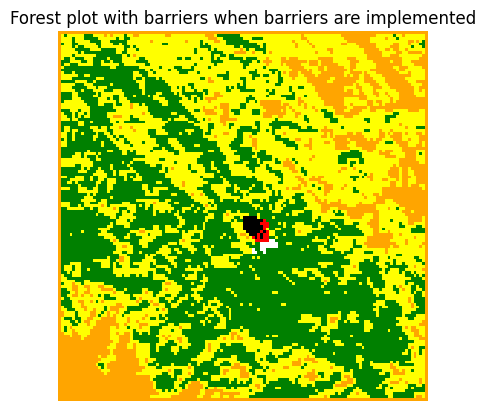

Random placement placed at timestep 4


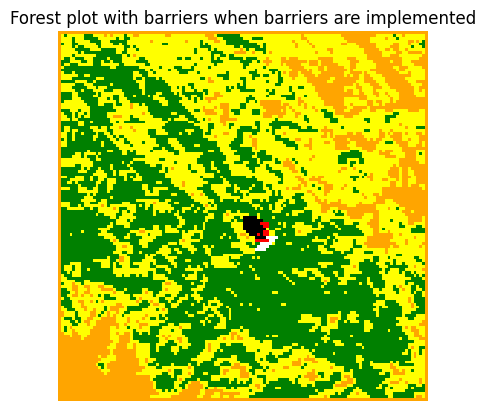

No Barrier: Time Step 12


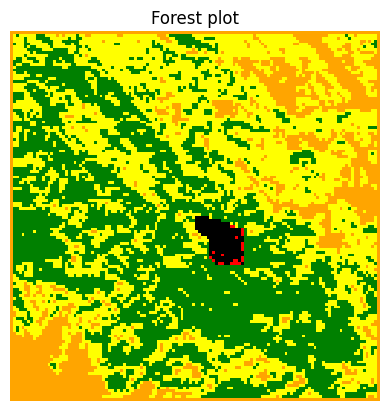

DQN forest: Time Step 12


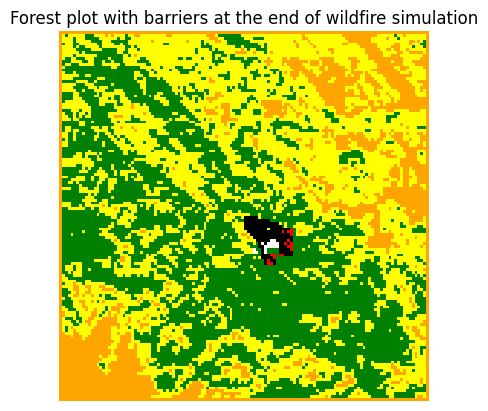

Random forest: Time Step 12


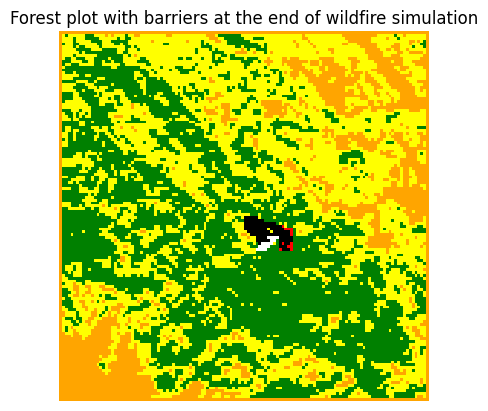


The burnt area is the minimum burnt difference
Saving weights...
Weights saved
Epoch:  0  completed
Simulation end time: 12
Epoch:  1  completed
Simulation end time: 12
Epoch:  2  completed
Simulation end time: 12
Epoch:  3  completed
Simulation end time: 12
Epoch:  4  completed
Simulation end time: 12
Epoch:  5  completed
Simulation end time: 12
Epoch:  6  completed
Simulation end time: 12
Epoch:  7  completed
Simulation end time: 12
Epoch:  8  completed
Simulation end time: 12
Epoch:  9  completed
Simulation end time: 12
DQN placement placed at timestep 4


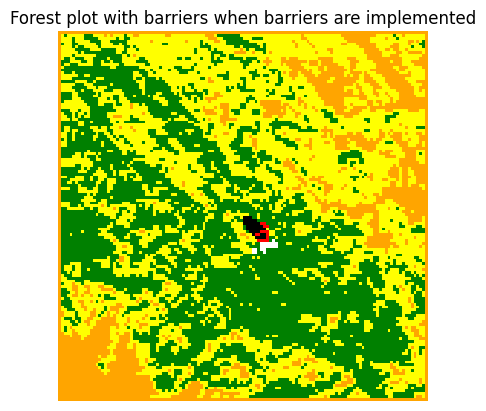

Random placement placed at timestep 4


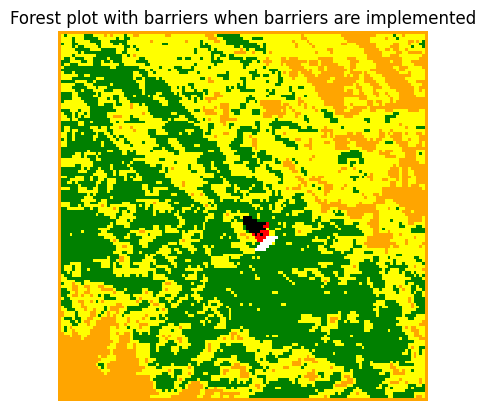

No Barrier: Time Step 12


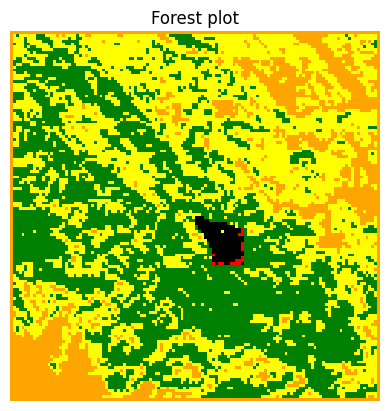

DQN forest: Time Step 12


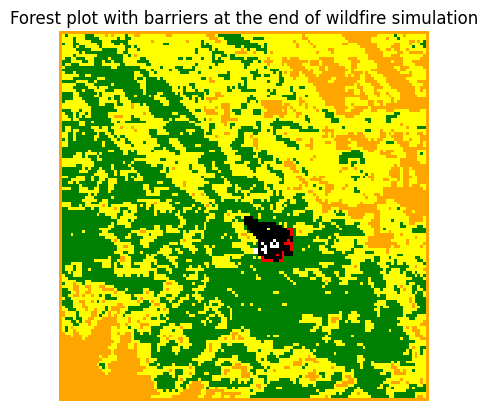

Random forest: Time Step 12


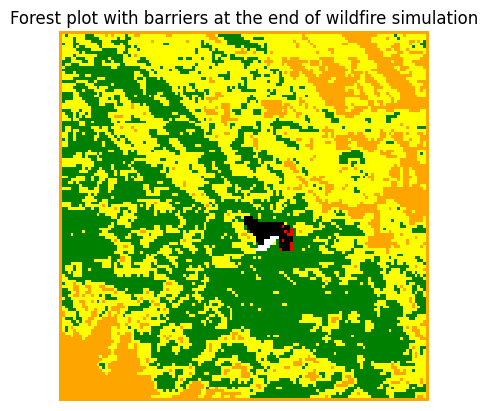

Epoch:  10  completed
Simulation end time: 12
Epoch:  11  completed
Simulation end time: 12
Epoch:  12  completed
Simulation end time: 12
Epoch:  13  completed


In [ ]:

import gc #to clear RAM
import glob #to clear folders
import os

Network = DQN(2, [10,10], summary = True) #action space of 2, input image shape of (10,10,1) for each neighbour cell
#Loading pretrained weights on human interactions
#Network.model.load_weights("drive/MyDrive/ML/Pretrain_weights.h5")
#Loading pretrained DQN weights
Network.model.load_weights('drive/MyDrive/ML/DQN_weights.h5')


burnt_diff = []
emp_burnt_area = []
bar_burnt_area = []
rand_burnt_area = []
buffer_index = 0
loss_values = []
lr = []
original_forest = forest #this is so that the original forest map (without any burning is saved)
num_epochs = 121
num_simulations = 1
bar_length = 20

for epoch in range(num_epochs):
  for sim in range(num_simulations):
    #time of simulation and time step between barriers and time at which original barriers are placed
    time = 0
    time_step = 8
    time_bar = 4
    time_sim = 8
    #computing a new simulated fire (ignition is from the centre of the forest every time)
    current_forest, alt, wind = simulation(1, time_bar, time_bar, False) #if no barriers i.e. simulation 1 then it only returns forest after simulation, alt, and wind
    Network.burning_cells(current_forest, wind) #find the burning cells in each case
    Network.choose_actions(current_forest, alt, wind, bar_length)
    #Network.manage_buffer_file() #makes sure only files in empty directory can be accessed
    time += time_bar
    next_state, burnt_area_diff, done = Network.calc_reward(current_forest, epoch_num = epoch, time = time, time_sim = time_sim, sim_whole = True)
    #store memory
    for i in range(len(Network.bar_reward)):
      Network.store_episode(Network.bar_input_states[i], Network.bar_cells[i], 0, Network.bar_reward[i],
                            next_state, Network.bar_Q_val[i], done) #as an action of 0 means place barrier
    for i in range(len(Network.emp_reward)):
      Network.store_episode(Network.emp_input_states_used[i], Network.used_emp_cells[i], 1, Network.emp_reward[i],
                            next_state, Network.emp_Q_val_used[i], done)
    time += time_sim
    done = True
    while done == False and time < 25:
      print("Simulation time:", time)
      temp_bar = np.zeros(np.shape(next_state)).astype(int)
      Network.burning_cells(next_state, wind)
      Network.choose_actions(next_state, alt, wind, bar_length)
      next_state, burnt_area_diff, done = Network.calc_reward(next_state, epoch_num = epoch, time = time, time_sim = time_sim, sim_whole = True)
      time += time_step
      #store memory
      for i in range(len(Network.bar_reward)):
          Network.store_episode(Network.bar_input_states[i],Network.bar_cells[i], 0, Network.bar_reward[i],
                              next_state, Network.bar_Q_val[i], done) #as an action of 0 means place barrier
      for i in range(len(Network.emp_reward)):
          Network.store_episode(Network.emp_input_states_used[i],Network.used_emp_cells[i], 1, Network.emp_reward[i],
                            next_state, Network.emp_Q_val_used[i], done)

      #next_state, burnt_area, alt0, wind0, stage2 = simulation(2, time+time_step, time+time_step, False, current_forest,
      #                                  time_sim, temp_bar, temp_bar,
      #                                  Network.length_of_barrier, 0)

    print("Simulation end time:", time)
    Network.bar_Q_val = None
    Network.emp_Q_val = None
    Network.bar_input_states = None
    Network.emp_input_states = None #reducing RAM

    #once theres been num_simulations simulations, update network
    if sim == (num_simulations-1):
      Network.update_explor_prob()
      #record learning rate (loss recorded within train method)
      Network.train()
      #Network.cyclic_lr(0.00001,0.07, epoch) #exponetial factor is 0.02

      #clear Bar Forests and Emp Forests directories
      #os.chdir("/content/drive/MyDrive/ML/Bar Forests")
      #for f in os.listdir():
      #  os.remove(f)
      #os.chdir("/content/drive/MyDrive/ML/Emp Forests")
      #for f in os.listdir():
      #  os.remove(f)



  if epoch == (num_epochs-1):
    emp_burnt, bar_burnt, rand_burnt = Network.evaluate_net(current_forest, alt, wind)
    Network.input_forest = None #to reduce memory
    burnt_diff.append(bar_burnt_area - emp_burnt)
    emp_burnt_area.append(emp_burnt)
    bar_burnt_area.append(bar_burnt)
    rand_burnt_area.append(rand_burnt)
    plot_forest(initial_DQN, True, True)
    plot_forest(initial_rand, True, True)
    plot_forest(emp_state)
    plot_forest(bar_state, True)
    plot_forest(rand_state, True)
    del bar_state
    del emp_state
    del emp_burnt
    del rand_state
    del bar_burnt
    del rand_burnt
    gc.collect()

  if epoch%10 == 0: #Evaluates the DQN after every 10th training
    emp_burnt, bar_burnt, rand_burnt, bar_state, time = Network.evaluate_net(current_forest, alt, wind, rand = True, epoch = epoch) #, emp_state, bar_state, rand_state, initial_DQN, initial_rand\
     #use random for when DQN simulates over many time steps
    Network.input_forest = None #to reduce memory

    #To plot different burnt areas
    burnt_diff.append(emp_burnt - bar_burnt)
    emp_burnt_area.append(emp_burnt)
    bar_burnt_area.append(bar_burnt)
    rand_burnt_area.append(rand_burnt)


    #To check whether to stop early or not - stop early if no burning cells
    if check_burning(bar_state) == True or time < 20:
      pass
    else:
      print()
      print("There are no burning cells, simulating again to see if DQN has found optimal placement")
      #if there are no burning cells after evaluating do one further evaluation run to see if there are no burning cells again and if so stop simulation
      emp_burnt, bar_burnt, rand_burnt, bar_state, time = Network.evaluate_net(current_forest, alt, wind, rand = True, epoch = epoch)
      Network.input_forest = None #to reduce memory
      del emp_burnt, rand_burnt, bar_burnt
      gc.collect()
      #checking for no burnt cells again
      if check_burning(bar_state):
        print("The DQN wasn't able to stop burning again, so training will continue")
        print("Saving weights...")
        Network.model.save_weights('drive/MyDrive/ML/DQN_weights.h5', overwrite = True)
        print("Weights saved")
      else:
        print("The DQN was able to stop burning again")
        print("Saving weights...")
        Network.model.save_weights('drive/MyDrive/ML/DQN_weights.h5', overwrite = True)
        print("Weights saved")
        break

    if bar_burnt < Network.min_burnt_diff: #save weights if burnt diff is a minimum
      print()
      print("The burnt area is the minimum burnt difference")
      print("Saving weights...")
      Network.model.save_weights('drive/MyDrive/ML/DQN_weights.h5', overwrite = True)
      print("Weights saved")
      Network.min_burnt_diff = bar_burnt


    #clearning memory
    try:
      del bar_state
      del emp_state
      del emp_burnt
      del rand_state
      del bar_burnt
      del rand_burnt
      gc.collect()
    except:
      pass



    #clearing RAM
    del next_state
    del current_forest
    del burnt_area_diff
    del alt
    del wind
    gc.collect()


  print('Epoch: ',epoch,' completed')


## Plotting Burnt area and burnt area difference

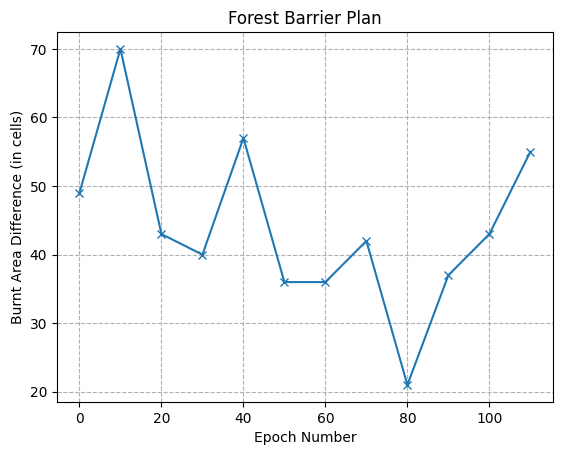

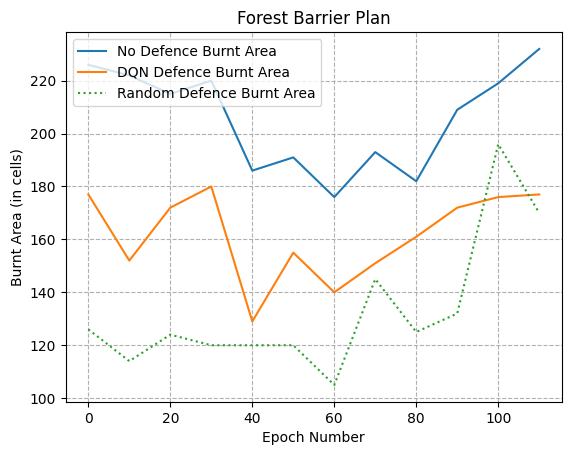

In [18]:
##Num Epoch: 500, batch size: 64, learning rate: 0.001, exploration decay: 0.01
#avg_burntcell_diff5 = avg_burntcell_diff
import matplotlib.pyplot as plt
import numpy as np

x_axis = [0,10,20,30,40,50,60,70,80,90,100,110]
plt.plot(x_axis, burnt_diff, marker = 'x')
plt.ylabel("Burnt Area Difference (in cells)")
plt.xlabel("Epoch Number")
plt.title("Forest Barrier Plan")
plt.grid(linestyle = 'dashed')
plt.show()
plt.close()

x_axis = [0,10,20,30,40,50,60,70,80,90,100,110]
plt.plot(x_axis, emp_burnt_area, linestyle = '-', label = "No Defence Burnt Area")
plt.plot(x_axis, bar_burnt_area, label = "DQN Defence Burnt Area")
plt.plot(x_axis, rand_burnt_area, linestyle = 'dotted', label = "Random Defence Burnt Area")
plt.ylabel("Burnt Area (in cells)")
plt.xlabel("Epoch Number")
plt.title("Forest Barrier Plan")
plt.grid(linestyle = 'dashed')
plt.legend(loc = 'upper left')
plt.show()
plt.close()


## Training with non terminal simulation

Run next code block for slightly different DQN class that allows non terminal states

In [ ]:
#Model, input is the 128x128 image of the forest fire.
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error
import os
import cv2
import shutil
import gc
import copy
bar_directory = r'/content/drive/MyDrive/ML/Bar Forests' #changing directory within google drive
emp_directory = r'/content/drive/MyDrive/ML/Emp Forests'
buffer_directory = r'/content/drive/MyDrive/ML/Buffer Forests'
filename = r"bar_input_forest index"
emp_filename = r"emp_input_forest index"

class DQN_Multi():
  def __init__(self, action_size, input_shape, summary = False, whole_spread = False): #assuming input has dimension (10,10,1)

    """
  forest (array) - forest array up to point at which fire breaks should be placed
  action_size (int) - the size of the output layer of DQN
  input_shape (list) - a list containing the size of the inputs to DQN
  summary (bool) - a boolean of whether to output the summary of DQN
  whole_spread (bool) - a boolean controlling whether or not the entire wildfire spread will be simulated
  define some parameters and hyperparameters:
         "lr" : learning rate
         "gamma": discounted factor
         "exploration_proba_decay": decay of the exploration probability
         "batch_size": size of experiences we sample to train the DNN
    """
    self.input_row = input_shape[0]
    self.input_col = input_shape[1]

    #now forming DNN
    self._lr = 0.00028
    self._gamma = 0.000001
    self._exploration_prob_decay = 0.0275
    self._exploration_prob = 0.5
    self._batch_size = 48
    self._whole_spread = whole_spread

    #now creating a memory buffer
    #self.memory_buffer = {} #store as dictionary so that memorys can easily be replaced for google drive
    self.memory_buffer = [] #store as list so memory can easily be removed for none google drive
    self.max_memory_buffer = 750
    self.min_burnt_diff = 128*128 #the weights of min burnt difference will be saved

    #Now the DQN network
    self.model = Sequential()
    self.model.add(Conv2D(filters = 12, kernel_size = (2, 2), activation='relu',
    padding='same', input_shape = (self.input_row,self.input_col,4), data_format = "channels_last"))
    self.model.add(MaxPooling2D(pool_size = (2, 2), padding='same', input_shape = (self.input_row,self.input_col,4)))
    self.model.add(Flatten())
    #print(self.model.output_shape)
    self.model.add(Dense(units = 200, activation = 'relu', input_shape = (300,)))
    self.model.add(Dense(units = 100, activation = 'relu'))
    self.model.add(Dense(units = 64, activation = 'relu'))
    self.model.add(Dense(units = 32, activation = 'relu'))
    self.model.add(Dense(units = 16, activation = 'relu'))
    self.model.add(Dense(units = 8, activation = 'relu'))
    self.model.add(Dense(units = 2, activation = 'relu'))
    self.model.add(Dense(units = action_size, activation = 'linear'))


    self.model.compile(loss="mse",
                      optimizer = Adam(learning_rate = self._lr))
    if summary == True:
      self.model.summary()

  def burning_cells(self, forest, wind):
    """ This method is used to find the position of all of the burning cells for
    a given forest state
    forest (array) - forest state in question """
    self._burning_cells = []
    self._neighbour_coord = []
    self.burning_matrix = np.zeros(np.shape(forest))
    self.wind_matrix = np.zeros((self.input_row, self.input_col))
    self._too_close = []
    n_row = forest.shape[0]
    n_col = forest.shape[1]
    #getting the burning cells
    for row in range(1, n_row - 1):
      for col in range(1, n_col - 1):
        if forest[row][col] == 3:
          self._burning_cells.append((row, col))
          self.burning_matrix[row][col] == 1 #creating a matrix of 0s with 1s where the forest is burning

          #creating a grid of cells that are too close to burning cells (within a 5x5 grid of burning cells)
          for  neighbour_col in range(col - 2, col + 3):
            for neighbour_row in range(row - 2, row + 3):
              if (neighbour_row, neighbour_col) not in self._too_close:
               self._too_close.append((neighbour_row, neighbour_col))

          #getting the neighbours of burning cells to get a neighbours matrix (all neighbours will be the 'agents')
          for neighbour_col in range(col-5, col+6):
            for neighbour_row in range(row - 5, row + 6):  #looking at 10x10 grid around each burning cell to get neighbour cells
              if 0 <= neighbour_col < 128 and 0 <= neighbour_row < 128:
                if (neighbour_row, neighbour_col) not in self._neighbour_coord\
                and (neighbour_row, neighbour_col) not in self._too_close\
                and forest[neighbour_row][neighbour_col] != 3\
                and forest[neighbour_row][neighbour_col] !=4: #so we only upload new cells and cells that aren't burning, burnt, and far enough away from the burning cells to the neighbour coord and matrix
                  self._neighbour_coord.append((neighbour_row, neighbour_col))

    #wind matrix is different as wind is given in a 3x3 form to just convert this to 5x5 with extra cells being 0s
    #return the same wind matrix for each burning cell
    for i in range(3):
      for j in range(3):
        self.wind_matrix[i,j] = wind[i][j]


  def choose_actions(self, forest, alt, wind, length_of_barrier):
    """
    forest (array) - forest array up to point at which fire breaks should be placed
    length_of_barrier (int) - number of cells that can be firebreaks

    Save to drive process is commented out for now as this didn't seem to help RAM usage

    """
    self.input_forest = np.zeros((1, self.input_row, self.input_col, 4)) # 4 because there are 4 channels: input forest, altitude, wind, and burning cells
    self.bar_cells = []
    self.bar_Q_val = []
    self.bar_input_states = []
    self.emp_cells = []
    self.emp_Q_val = []
    self.emp_input_states = []
    self.length_of_barrier = length_of_barrier

    #randomly shufffle the neighbour cells
    np.random.shuffle(self._neighbour_coord)
    for cell in self._neighbour_coord:
      if random.random() <= self._exploration_prob: ##choosing a random action or not depending on episilon greedy function
        #need to obtain q val for later updates, so need to define the input forest
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i > 128 or y+j >= 128 or x+i < 0 or y+j < 0: #for when index is out of bounds
              self.input_forest[0][i][j][0] = 0 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds
            elif (x+i, y+j) in self.bar_cells:
              self.input_forest[0][i][j][0] = 1 # as barrier cell
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
            else:
              self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        q_vals = self.model.predict(self.input_forest, verbose = 0)
        if len(self.bar_cells) == self.length_of_barrier: #if max number of barrier cells already reached, just replace a random one. So choose a random index
          if random.choice([0,1]) == 0: #action 0 corresponds with cell being a firebreak
            index = random.randint(0,self.length_of_barrier-1)
            #move the cells with lower barrier q val to the none barrier lists
            self.emp_Q_val.append(self.bar_Q_val[index])
            self.emp_cells.append(self.bar_cells[index])
            self.emp_input_states.append(self.bar_input_states[index])
            #returning that cell to no longer be a barrier cell in the forest array
            self.bar_Q_val[index] = q_vals
            self.bar_cells[index] = cell
            self.bar_input_states[index] = self.input_forest

            #SAVING TO GOOGLE DRIVE
            #shutil.move(bar_directory+"/"+self.bar_input_states[index], emp_directory+"/"+
            #            emp_filename.replace("index", str(len(self.emp_input_states)))+".npy") #moving image into empty cell folder
            #self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
            #                                                                  "emp_input_forest"+" "+str(len(self.emp_input_states))))
            #update the barrier lists with the new cell
            #os.chdir(bar_directory)
            #np.save(filename.replace("index", str(index))+ ".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            #self.bar_input_states[index] = filename.replace("index", str(index))+".npy"

          else: #if choice is to make the cell a empty cell
            #os.chdir(emp_directory)
            self.emp_Q_val.append(q_vals)
            self.emp_cells.append(cell)
            self.emp_input_states.append(self.input_forest)
            #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
            #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

        #if max number of barrier cells is not reached yet
        elif len(self.bar_Q_val) < self.length_of_barrier: #getting barrier of cells of the correct size
          #os.chdir(bar_directory)
          #np.save(filename.replace("index", str(len(self.bar_input_states)))
          #+ ".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
          #self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")
          self.bar_input_states.append(self.input_forest)
          self.bar_Q_val.append(q_vals)
          self.bar_cells.append(cell)
          #forest[x][y] = 5



      #now for case where action is not random
      else:
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              self.input_forest[0][i][j][0] = 0 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds

            elif (x+i, y+j) in self.bar_cells:
              self.input_forest[0][i][j][0] = 1 # as barrier cell
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

            else:
              self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        q_vals = self.model.predict(self.input_forest, verbose = 0) #divide self.input forest by 5 in order to normalise input image

        if len(self.bar_cells) == self.length_of_barrier:
          if q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
            if q_vals[0][0] > np.min(np.array(self.bar_Q_val)[:,0,0]):
              index = np.argmin(np.array(self.bar_Q_val)[:,0,0])
              #move the cells with lower barrier q val to the none barrier lists
              self.emp_Q_val.append(self.bar_Q_val[index])
              self.emp_cells.append(self.bar_cells[index])
              self.emp_input_states.append(self.bar_input_states[index])

              self.bar_Q_val[index] = q_vals
              self.bar_cells[index] = cell
              self.bar_input_states[index] = self.input_forest

              #SAVING TO GOOGLE DRIVE
              #shutil.move(bar_directory+"/"+filename.replace("index", str(index))+".npy", emp_directory+
              #            "/"+emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")
              #self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
              #                                            "emp_input_forest"+" "+str(len(self.emp_input_states))))
              #self.bar_input_states[index] = self.input_forest
              #self.bar_input_states[index] = filename.replace("index", str(index))+".npy"
              #os.chdir(bar_directory)
              #np.save(filename.replace("index", str(index))+".npy", np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory

            else: #if q val is not greater than current barrier q vals
              self.emp_Q_val.append(q_vals)
              self.emp_cells.append(cell)
              self.emp_input_states.append(self.input_forest)
              #self.emp_input_states.append(self.input_forest)
              #os.chdir(emp_directory)
              #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
              #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
              #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

          elif q_vals[0][0] < q_vals[0][1]: #i.e. if it is better for the cell to be empty
            self.emp_Q_val.append(q_vals)
            self.emp_cells.append(cell)
            self.emp_input_states.append(self.input_forest)
            #os.chdir(emp_directory)
            #np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
            #            np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
            #self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")


        elif len(self.bar_Q_val) < self.length_of_barrier:  #getting barrier of cells of the correct size
          self.bar_Q_val.append(q_vals)
          self.bar_cells.append(cell)
          self.bar_input_states.append(self.input_forest)
          #os.chdir(bar_directory)
          #np.save(filename.replace("index", str(len(self.bar_input_states)))+".npy",
          #                         np.reshape(self.input_forest, (1,self.input_row,self.input_col,4))) #save image to filename in bar_directory
          #self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")


    return


  def update_explor_prob(self):
    """Updates exploration probability using episilon greedy policy"""

    self._exploration_prob = self._exploration_prob * np.exp(-self._exploration_prob_decay)


  def calc_reward(self, forest, epoch_num, time, time_sim = 16, sim_whole = False):
    """ Calculates the reward for a fire barrier set up. Reward is determined by
    the difference in burnt/burning area before and after the fire breaks are
    placed. Reward depends on if action is a barrier or empty.
    forest (array) - forest array up to point at which fire breaks should be placed
    time (int) - time at which to begin the simulations
    time_sim (int) - length of time simulation goes on for default of 16 time steps
                     (assuming current forest is 4 time step)
    epoch_num (int) - number of epochs that have been trained through
    sim_whole (bool) - whether or not simulation has none terminal states
    """
    temp_bar = np.zeros(np.shape(forest)).astype(int) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest)).astype(int)
    self.bar_reward = []
    self.emp_reward = []
    self.emp_input_states_used = []
    self.emp_Q_val_used = []
    self.used_emp_cells = []
    x_burning = []
    y_burning = []
    repeat_bar = [] #keeps track of bad barriers so we don't reward them for being connected if they are bad
    for bar in self.bar_cells:
      x,y = bar
      if forest[x][y] == 5 or forest[x][y] == 3: #if barrier is placed on a cell that is already burnt or already a barrier cell
        repeat_bar.append(bar)
      else:
        per_bar[x][y] = 5 #barrier forest updates with barriers

    #must do no barrier first or else the simulation will remember the barrier
    final_forest, burnt_area, alt0, wind0, stage2 = simulation(2, time, time, False, forest,
                                        time+time_sim, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)

    bar_final_forest, bar_burnt_area, alt1, wind1, stage2 = simulation(2, time, time, False,
                                                  forest, time+time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0)
    #per_bar = guessbar(self, "SE", diagon = True)
    #rand_final_forest, burnt_area, alt, wind, initial_rand = simulation(2, time, time, False,
    #                                              forest, time+time_sim, per_bar,
    #                                              temp_bar, self.length_of_barrier,
    #                                              0)

    #Finding burning cells so that we can determine the spread of burning cells
    for row in range(1, bar_final_forest.shape[0] - 1):
      for col in range(1, bar_final_forest.shape[0] - 1):
        if bar_final_forest[row][col] == 3:
          x_burning.append(col)
          y_burning.append(row)

    #if considering the whole wildfire event at this stage check for any burning cells to determine if stage is terminal or not
    done = True
    if sim_whole:
      for row in bar_final_forest:
        if done == False:
          break
        for num in row:
          if num == 3:
            done = False
            continue
      #saving weights
      if done == True:
        print("No burning cells")
        print("Saving weights...")
        self.model.save_weights('drive/MyDrive/ML/DQN_weights.h5', overwrite = True)
        print("Weights saved")


    del stage2 #as we don't need that here
    burnt_area_diff = burnt_area - bar_burnt_area #total burnt area difference, used for evaluation

    #reward for barrier cells
    connected = [] #used to assign a reward if all cells are connected
    for cell in self.bar_cells:
      if cell in repeat_bar:
        self.bar_reward.append(-1)
      else:
        x,y = cell
        bar_burnt = 0
        burnt = 0
        bar_count = 0 #counting all barrier cells in 10x10 grid as barrier cell is worse than not burnt
        not_near_burning_cells = True
        not_touching_bar = True
        touching = 0
        for i in range(-8, 8):
          for j in range(-8, 8):
            if 0 <= x+i < 128 and 0 <= y+j < 128:
              if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
                bar_burnt += 1
              if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
                burnt += 1
              if bar_final_forest[x+i][y+j] == 5:
                bar_count += 1
              if -4 < i < 4 and -4 < j < 4:
                if i == j == 0:
                  pass
                else:
                  if bar_final_forest[x+i][y+j] == 4 or bar_final_forest[x+i][y+j] == 3: #makes sure cells are touching, or near burning cells
                    not_near_burning_cells = False

                  if -2 < i < 2 and -2 < j < 2:
                    if bar_final_forest[x+i][y+j] == 5:
                      not_touching_bar = False
                      touching += 1
                      if len(connected) == 0: #to initially obtain connected cells
                        connected.append((x+i, y+j))
                        connected.append((x, y))
                      elif len(connected) >= 2 and (x+i, y+j) in connected and (x,y) not in connected: #i.e. cell is touching a cell in connected but is not in connected itself
                        connected.append((x, y))

        burnt_diff = burnt - bar_burnt - 10 #(include -15 so that burnt diff needs to be larger)
        #Burnt area rewards
        #if burnt_diff < -50:
        #  self.bar_reward.append(burnt_diff/50)
        if burnt_diff < 0:
          #self.bar_reward.append(-0.75*(np.exp((-burnt_diff/50))/(np.exp(3)*np.exp(burnt_diff/25))))
          self.bar_reward.append(burnt_diff/64) #as 20 is likely max burnt diff so this normalises the reward

        if burnt_diff == 0:
          self.bar_reward.append(-1/256) #assigning a small negative value for 0 as we want a positive burnt diff

        if burnt_diff > 0:
          self.bar_reward.append((burnt_diff+10)/64)
          #self.bar_reward.append((np.exp((burnt_diff/50))/(np.exp(3)*np.exp(-burnt_diff/25))))
        #if burnt_diff >50:
        #  self.bar_reward.append(burnt_diff/50)

        #Reward for not being near burning celss
        if not_near_burning_cells:
          self.bar_reward[-1] -= 1/8 #add a negative reward if the barrier cell has no burnt cells around it (its probably wrong)

        #Reward for not touching other barrier cells
        #if not_touching_bar:
        #  self.bar_reward[-1] -= 1/64 #add a negative reward for barrier cell not touching any other barrier cells
        #if touching >= 2: #when touching more barriers
        #  self.bar_reward[-1] += (1/64)

        #Reward to ensure DQN doesn't just form a cluster of barrier cells without reducing burnt area
        if bar_count:
          self.bar_reward[-1] -= (bar_count/2560)
        #Adding the burning cell spread reward
        #if burning_spread_rew:
        #  self.bar_reward[-1] += burning_spread_rew

    #reward for empty cells
    for i in range(int(len(self.emp_cells)/5)): #this is ind
      input_state = random.choice(self.emp_input_states)
      self.emp_input_states_used.append(input_state) #randomly selects empty input states to actually use
      index = self.emp_input_states.index(input_state)
      self.emp_input_states.remove(input_state) #removes from self.input_states so as not to repeat values
      self.emp_Q_val_used.append(self.emp_Q_val[index])
      self.used_emp_cells.append(self.emp_cells[index])
      cell = self.emp_cells[index]
      x,y = cell
      bar_burnt = 0
      burnt = 0
      for i in range(-8, 8):
        for j in range(-8, 8):
          if 0 <= x+i < 128 and 0 <= y+j < 128:
            if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
              bar_burnt += 1
            if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
              burnt += 1


      burnt_diff = burnt - bar_burnt - 10
      #if burnt_diff < -50:
      #  self.emp_reward.append(burnt_diff/400)
      if burnt_diff < 0:
        #self.emp_reward.append(-0.1*(np.exp((-burnt_diff/50))/(np.exp(3)*np.exp(burnt_diff/25))))
        self.emp_reward.append(burnt_diff/512)
      if burnt_diff == 0:
        self.emp_reward.append(-1/1024) #assigning a small negative value for 0 as we want a positive burnt diff
      if burnt_diff > 0:
        #self.emp_reward.append(0.1*(np.exp((burnt_diff/50))/(np.exp(3)*np.exp(-burnt_diff/25))))
        self.emp_reward.append((burnt_diff+10)/512)
      #if burnt_diff >50:
      #  self.emp_reward.append(burnt_diff/572)
      #if burnt_diff < 0:
      #  self.emp_reward.append(burnt_diff/100) #normalised reward
      #if burnt_diff == 0:
      #  self.emp_reward.append(0) #assigning a small negative value for 0 as we want a positive burnt diff
      #if burnt_diff > 0:
      #  self.emp_reward.append(burnt_diff/100)
      #if len(self.bar_cells) < self.length_of_barrier: #punishing empty cells for being empty if not enough barriers are deployed
      #  self.emp_reward[-1] -= -1


    del final_forest
    gc.collect()
    #Rewarding touching barriers
    for cell in connected:
      index = self.bar_cells.index(cell)
      self.bar_reward[index] += len(connected)/3840 #so that if all connected reward is 1/128


    return bar_final_forest, burnt_area_diff, done

  def save_memory(self, current_state, action, reward, next_state, q_current_state, done):
    """ This meothod saves a memory to the memory buffer when input states are saved to google drive"""
    #move file to new folder where memories are stored
    global buffer_index
    if action == 0:
      shutil.move(bar_directory+"/"+current_state, buffer_directory+"/"+
                        filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")) #modulo operator used to only allow buffer index between 0-249
      current_state =  filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy") #change current_state to point towards the new correct file
    else:
      shutil.move(emp_directory+"/"+current_state, buffer_directory+"/"+
                        emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy"))
      current_state = emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")

    self.memory_buffer[buffer_index%self.max_memory_buffer] = {
        "current_state":current_state,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      }
  def store_episode(self,current_state, cell, action, reward, next_state, q_current_state, done):
    """This method stores the episode to memory using a dictionary"""
    if len(self.memory_buffer) < self.max_memory_buffer:
      self.memory_buffer.append({
        "current_state":current_state,
        "cell":cell,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      })
      return

    elif len(self.memory_buffer) >= self.max_memory_buffer:
      self.memory_buffer.pop(0)
      self.memory_buffer.append({
        "current_state":current_state,
        "cell": cell,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      })
      return

  #at the end of the episode train the network
  def train(self, loss = False):
    """ This method is used to train the DQN
    loss (bool) - whether or not to use cyclic LR and track loss
    for now the process of training via input states saved to google drive is commented out"""
    mem_buff = copy.deepcopy(self.memory_buffer)
    np.random.shuffle(mem_buff)
    batch_sample = mem_buff[0:self._batch_size]
    del mem_buff

    # We iterate over the selected experiences
    for experience in batch_sample:
      loss_val = 0
      q_current_state = experience["q_current_state"]
      input_state = experience["current_state"]
      input_state = np.reshape(input_state, (1,self.input_row,self.input_col,4))
      # We compute the Q-target using Bellman optimality equation
      q_target = experience["reward"]
      if not experience["done"]: #for the time being all experience["done"] will be true
        next_state = input_state
        cell = experience["cell"]
        x,y = cell
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              next_state[0][i][j][0] = 1 #as this is 'no fuel' cell
            else:
              next_state[0][i][j][0] = experience["next_state"][i][j]
        q_target = q_target + self._gamma*np.max(self.model.predict(next_state, verbose = 0))
      q_current_state[0][experience["action"]] = q_target

      # train the model
      history = self.model.fit(input_state, q_current_state, verbose=0)
      if loss:
        loss_val += self.model.history.history['loss'][0] #to sum the loss to the loss for this minibatch
    if loss:
      self.loss_value = loss_val/self._batch_size #loss/self._batch_size returns mean loss for all minibatch training


  def cyclic_lr(self, start_lr, factor, epoch):
    """ This method is used to find the range of optimial learning rates by exponentially increasing learing rate
        start_lr (float) - learing rate value to begin the cyclic exploration
        factor (float) - exponential factor
        epoch (int) - number of training batches there has been """
    global lr, loss_value
    lr.append(self._lr)
    loss_values.append(self.loss_value)
    self._lr = start_lr * np.exp(epoch*factor)


  def evaluate_net(self, forest, alt, wind, epoch, time_step = 8, barrier_time = 4, rand = False):
    """This method is used to calculate the Networks best performance
      forest (array) - forest array up to point at which fire breaks should be placed
      time_step (int) - length of time simulation goes on for default of 16 time steps
                    (assuming current forest is 3 time step)
      rand (bool) - whether or not ignition is random """
    self._best_cells = []
    self._best_qval = []
    self.input_forest = np.zeros((1, self.input_row, self.input_col,4))
    self.burning_cells(forest, wind)
    time = barrier_time
    for cell in self._neighbour_coord:
      x,y = cell
      #obtain input matrix
      for i in range(-5, 5):
        for j in range(-5, 5):
          if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
            self.input_forest[0][i][j][0] = 0 #as this is 'no fuel' cell
            self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
            self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
            self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds

          elif (x+i, y+j) in self._best_cells:
            self.input_forest[0][i][j][0] = 1 # as barrier cell
            self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
            self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
            self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

          else:
            self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
            self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
            self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
            self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

      q_vals = self.model.predict(self.input_forest, verbose = 0)
      if len(self._best_cells) < self.length_of_barrier:
          self._best_qval.append(q_vals)
          self._best_cells.append(cell) #we don't need to record the input states so we aren't doing that here
      elif q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
        if q_vals[0][0] > np.min(np.array(self._best_qval)[:,0,0]):
          index = np.argmin(np.array(self._best_qval)[:,0,0])
          #update the barrier lists with the new cell
          self._best_qval[index] = q_vals
          self._best_cells[index] = cell

    #now that we have the optimal cells for the barriers to be, we must simulate the fire spread
    temp_bar = np.zeros(np.shape(forest)) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest))

    #print(self._best_cells)
    for bar in self._best_cells:
      x,y = bar
      per_bar[x][y] = 5 #makes it a permenant barrier
    #must do no barrier first or else the simulation will remember the barrier

    #simulating
    final_forest, burnt_area, alt, wind, initial_emp = simulation(2, time, time, False, forest,
                                        time+time_step, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)
    bar_final_forest, bar_burnt_area, alt, wind, initial_DQN = simulation(2,time, time, False,
                                                  forest, time+time_step, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #bar_forest_history2,
    if rand:
      per_bar = guessbar(self, "SE", diagon = True)
    else:
      per_bar, cells = fire_break(forest, 75, 73)
    random_final_forest, rand_burnt_area, alt, wind, initial_rand = simulation(2,time, time, False,
                                                  forest, time+time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #simulating randomly putting a 10x3 barrier at (75,75)
    time += time_step
    done = True
    if check_burning(bar_final_forest):
      done = False

    #Plotting forests
    print("DQN placement placed at timestep 4")
    plot_forest(initial_DQN, True, True)
    print("Random placement placed at timestep 4")
    plot_forest(initial_rand, True, True)
    print("No Barrier: Time Step", time)
    plot_forest(final_forest)
    print("DQN forest: Time Step", time)
    plot_forest(bar_final_forest, True)
    print("Random forest: Time Step", time)
    plot_forest(random_final_forest, True)
    #done = True #Comment out to run the whole simulation
    while done == False and time < 25:
      print("Eval time (before sim):", time)
      temp_bar = np.zeros(np.shape(final_forest))
      per_bar = np.zeros(np.shape(final_forest))
      self.burning_cells(bar_final_forest, wind)
      #finding best cells
      self._best_cells = []
      self._best_qval = []
      for cell in self._neighbour_coord:
        x,y = cell
        #obtain input matrix
        for i in range(-5, 5):
          for j in range(-5, 5):
            if x+i >= 128 or y+j >= 128 or x+i < 0 or y+j < 0:
              self.input_forest[0][i][j][0] = 0 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds


            else:
              self.input_forest[0][i][j][0] = bar_final_forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i][j]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

        q_vals = self.model.predict(self.input_forest, verbose = 0)
        if len(self._best_cells) < self.length_of_barrier:
          self._best_qval.append(q_vals)
          self._best_cells.append(cell) #we don't need to record the input states so we aren't doing that here
        elif q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
          if len(self._best_cells) == self.length_of_barrier:
            if q_vals[0][0] > np.min(np.array(self._best_qval)[:,0,0]):
              index = np.argmin(np.array(self._best_qval)[:,0,0])
              #update the barrier lists with the new cell
              self._best_qval[index] = q_vals
              self._best_cells[index] = cell

      #print(self._best_cells)
      #DQN barrier
      for bar in self._best_cells:
        x,y = bar
        per_bar[x][y] = 5 #makes it a permenant barrier
      bar_final_forest, burnt_area, alt0, wind0, stage2 = simulation(2, time, time, False, bar_final_forest,
                                        time+time_step, per_bar, temp_bar,
                                        self.length_of_barrier, 0)
      #Random Barrier
      per_bar = guessbar(self, "SE", diagon = True)
      random_final_forest, rand_burnt_area, alt, wind, initial_rand = simulation(2, time, time, False,
                                                  random_final_forest, time+time_step, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0)
      final_forest, burnt_area, alt, wind, initial_emp = simulation(2, time, time, False, final_forest,
                                        time+time_step, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)

      time += time_step
      print("Empty forest: Time Step", time)
      plot_forest(final_forest)
      print("DQN forest: Time Step", time)
      plot_forest(bar_final_forest, True)
      print("Random forest: Time Step", time)
      plot_forest(random_final_forest, True)

    self._best_cells = None
    self._best_qval = None
    alt = None
    wind = None
    del initial_emp
    del q_vals
    del self.input_forest
    gc.collect()
    return burnt_area, bar_burnt_area, rand_burnt_area, bar_final_forest, time


  def manage_buffer_file(self):
    """ Manages empty files so that only files in bar directory are accessed"""
    os.chdir(bar_directory)
    for filename in self.memory_buffer:
      if filename["current_state"] not in os.listdir():
        self.memory_buffer.remove(filename)

    return self.emp_input_states


The next code block is used to train DQN that allows non terminal states

In [ ]:
import gc #to clear RAM
import glob #to clear folders
import os

burnt_diff = []
emp_burnt_area = []
bar_burnt_area = []
rand_burnt_area = []
buffer_index = 0
loss_values = []
lr = []
original_forest = forest #this is so that the original forest map (without any burning is saved)

#Defining constants over training
bar_length = 20
num_epochs = 200
num_simulations = 1
Network = DQN_Multi(2, [10,10], summary = True) #action space of 2, input image shape of (10,10,1) for each neighbour cell
#LOAD weights from DQN for with only terminal states
Network.model.load_weights('drive/MyDrive/ML/DQN_weights')

for epoch in range(num_epochs):
  for sim in range(num_simulations):
    #time of simulation and time step between barriers and time at which original barriers are placed
    time = 0
    time_step = 8
    time_bar = 4
    time_sim = 8
    #computing a new simulated fire (ignition is from the centre of the forest every time)
    current_forest, alt, wind = simulation(1, time_bar, time_bar, False) #if no barriers i.e. simulation 1 then it only returns forest after simulation, alt, and wind
    Network.burning_cells(current_forest, wind) #find the burning cells in each case
    Network.choose_actions(current_forest, alt, wind, bar_length)
    #Network.manage_buffer_file() #makes sure only files in empty directory can be accessed
    time += time_bar
    next_state, burnt_area_diff, done = Network.calc_reward(current_forest, epoch_num = epoch, time = time, time_sim = time_sim, sim_whole = True)
    #store memory
    for i in range(len(Network.bar_reward)):
      Network.store_episode(Network.bar_input_states[i], Network.bar_cells[i], 0, Network.bar_reward[i],
                            next_state, Network.bar_Q_val[i], done) #as an action of 0 means place barrier
    for i in range(len(Network.emp_reward)):
      Network.store_episode(Network.emp_input_states_used[i], Network.used_emp_cells[i], 1, Network.emp_reward[i],
                            next_state, Network.emp_Q_val_used[i], done)
    time += time_sim

    while done == False and time < 25:
      print("Simulation time:", time)
      temp_bar = np.zeros(np.shape(next_state)).astype(int)
      Network.burning_cells(next_state, wind)
      Network.choose_actions(next_state, alt, wind, bar_length)
      next_state, burnt_area_diff, done = Network.calc_reward(next_state, epoch_num = epoch, time = time, time_sim = time_sim, sim_whole = True)
      time += time_step
      #store memory
      for i in range(len(Network.bar_reward)):
          Network.store_episode(Network.bar_input_states[i],Network.bar_cells[i], 0, Network.bar_reward[i],
                              next_state, Network.bar_Q_val[i], done) #as an action of 0 means place barrier
      for i in range(len(Network.emp_reward)):
          Network.store_episode(Network.emp_input_states_used[i],Network.used_emp_cells[i], 1, Network.emp_reward[i],
                            next_state, Network.emp_Q_val_used[i], done)

      #next_state, burnt_area, alt0, wind0, stage2 = simulation(2, time+time_step, time+time_step, False, current_forest,
      #                                  time_sim, temp_bar, temp_bar,
      #                                  Network.length_of_barrier, 0)

    print("Simulation end time:", time)
    Network.bar_Q_val = None
    Network.emp_Q_val = None
    Network.bar_input_states = None
    Network.emp_input_states = None #reducing RAM

    #once theres been num_simulations simulations, update network
    if sim == (num_simulations-1):
      Network.update_explor_prob()
      #record learning rate (loss recorded within train method)
      Network.train()



  if epoch%10 == 0: #Evaluates the DQN after every 10th training
    emp_burnt, bar_burnt, rand_burnt, bar_state, time = Network.evaluate_net(current_forest, alt, wind, time_step =8, rand = True, epoch = epoch) #, emp_state, bar_state, rand_state, initial_DQN, initial_rand\
     #use random for when DQN simulates over many time steps
    Network.input_forest = None #to reduce memory

    #To plot different burnt areas
    burnt_diff.append(emp_burnt - bar_burnt)
    emp_burnt_area.append(emp_burnt)
    bar_burnt_area.append(bar_burnt)
    rand_burnt_area.append(rand_burnt)


    #To check whether to stop early or not - stop early if no burning cells
    if check_burning(bar_state) == True or time > 25 and epoch > 10:
      pass
    else:
      print()
      print("There are no burning cells, simulating again to see if DQN has found optimal placement")
      #if there are no burning cells after evaluating do one further evaluation run to see if there are no burning cells again and if so stop simulation
      emp_burnt, bar_burnt, rand_burnt, bar_state, time = Network.evaluate_net(current_forest, alt, wind, rand = True, epoch = epoch)
      Network.input_forest = None #to reduce memory
      del emp_burnt, rand_burnt, bar_burnt
      gc.collect()
      #checking for no burnt cells again
      if check_burning(bar_state):
        print("The DQN wasn't able to stop burning again, so training will continue")
        print("Saving weights...")
        Network.model.save_weights('drive/MyDrive/ML/DQN_weights', overwrite = True)
        print("Weights saved")
      else:
        print("The DQN was able to stop burning again")
        print("Saving weights...")
        Network.model.save_weights('drive/MyDrive/ML/DQN_weights', overwrite = True)
        print("Weights saved")
        break

    if bar_burnt < Network.min_burnt_diff: #save weights if burnt diff is a minimum
      print()
      print("The burnt area is the minimum burnt difference")
      print("Saving weights...")
      Network.model.save_weights('drive/MyDrive/ML/DQN_weights', overwrite = True)
      print("Weights saved")
      Network.min_burnt_diff = bar_burnt


    #clearning memory
    try:
      del bar_state
      del emp_state
      del emp_burnt
      del rand_state
      del bar_burnt
      del rand_burnt
      gc.collect()
    except:
      pass



    #clearing RAM
    del next_state
    del current_forest
    del burnt_area_diff
    del alt
    del wind
    gc.collect()


  print('Epoch: ',epoch,' completed')





## Clearing google drive folders
storing input states for empty, barrier and buffer

In [ ]:
#to clear Bar Forests and Emp forests and buffer forests folders
import os
import cv2
import glob
import numpy as np
os.chdir("/content")
os.chdir("/content/drive/MyDrive/ML/Bar Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Emp Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Buffer Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())


FileNotFoundError: ignored

## Clearing Google drive trash

In [ ]:
#Clearning trash
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

for a_file in my_drive.ListFile({'q': "trashed = true"}).GetList():
    # print the name of the file being deleted.
    #print(f'the file "{a_file['title']}", is about to get deleted permanently.')
    # delete the file permanently.
    a_file.Delete()

HttpError: ignored